# Report
* 2-1. 주간 음원 변동 특이사항
* 3-1-1. 순위 급상승 음원
* 4-1-1. 기획사별 음원차트 진입 요약
* 4-1-2. 기획사 소셜미디어 관심도 요약
* 4-2-1. 소속사별 진입 음원
* 6\. 별첨

## 필요 라이브러리 로드

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os, math
import shutil

In [20]:
from selenium import webdriver
import chromedriver_autoinstaller as ca
import random, time

In [21]:
import platform
from matplotlib import font_manager, rc

# 한글 폰트 지정
path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

In [31]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False # 그래프에서 음수 표현 가능하도록 설정.
matplotlib.rcParams['figure.max_open_warning'] = 0 # 많은 그래프 생성시 오류 메세지 숨기기.

In [23]:
import seaborn as sns

## 이번주 날짜 설정

In [24]:
# 기간 설정(이번주)
start_date = '2022-05-09'
end_date = '2022-05-15'

In [25]:
# 작업 위치 고정
f_path = 'c:/data/Wantreez/Crawling/music'
try:
    os.chdir(f_path)
except:
    pass

In [26]:
# 현재 코드 위치
code_path = os.getcwd().replace('\\', '/')
code_path

'c:/data/Wantreez/Crawling/music'

## 5\. 별첨 + 급등음원 추출
* 음원 순위 변동 그래프 & 급등 음원 추출

In [30]:
# 한 그래프에 몇 개의 선 그래프 그릴지 설정
number = 10

[flo]20220509_20220515_mean_outliers.xlsx 출력
[bugs]20220509_20220515_mean_outliers.xlsx 출력
[genie]20220509_20220515_mean_outliers.xlsx 출력
[melon]20220509_20220515_mean_outliers.xlsx 출력
[vibe]20220509_20220515_mean_outliers.xlsx 출력


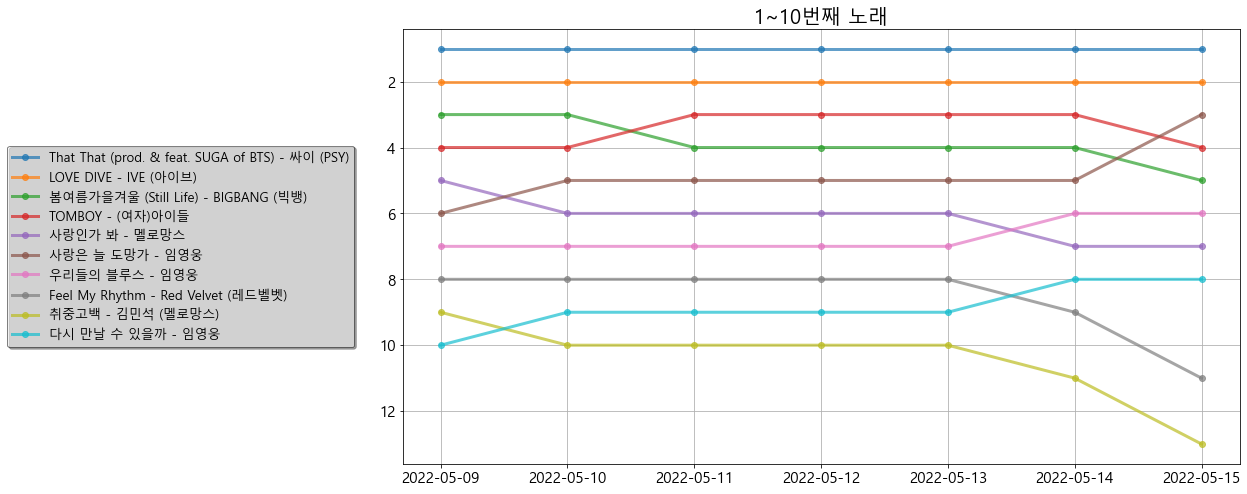

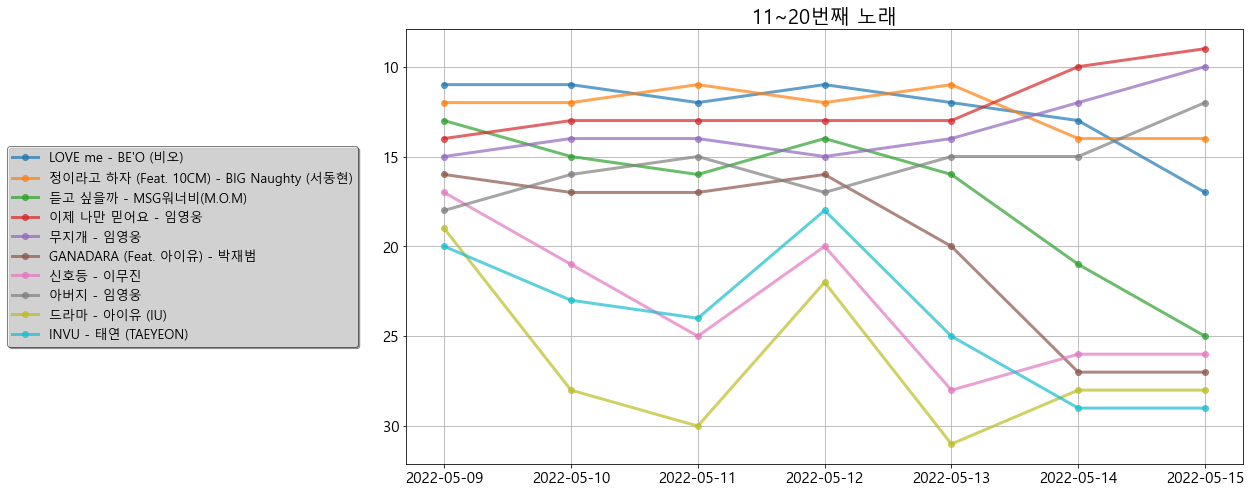

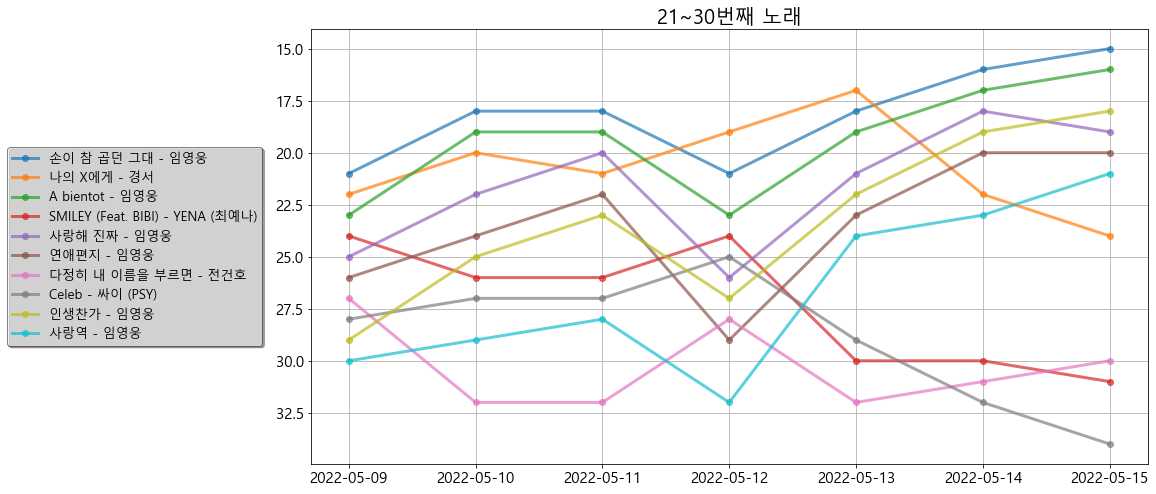

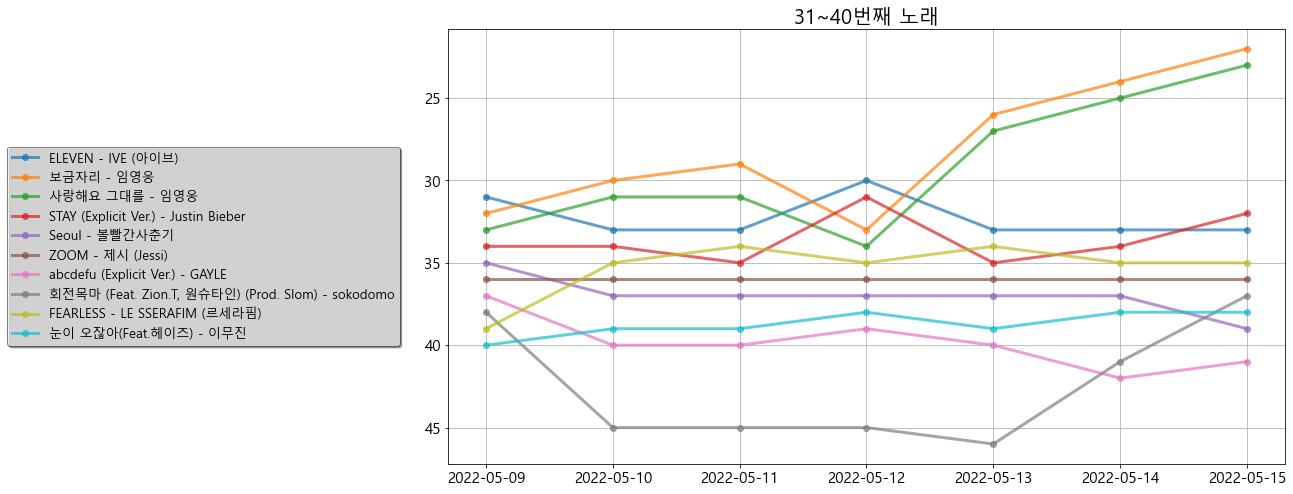

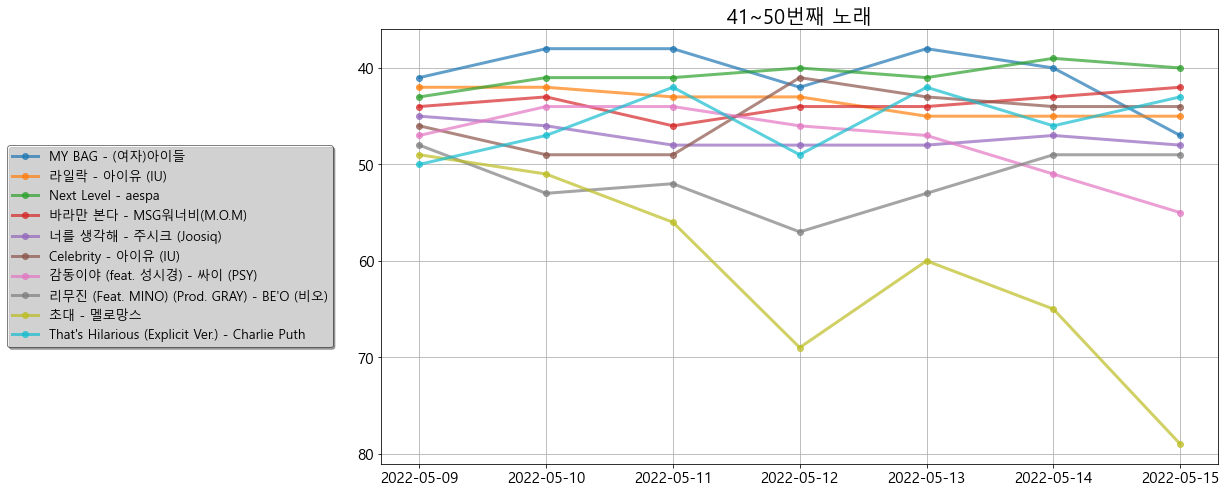

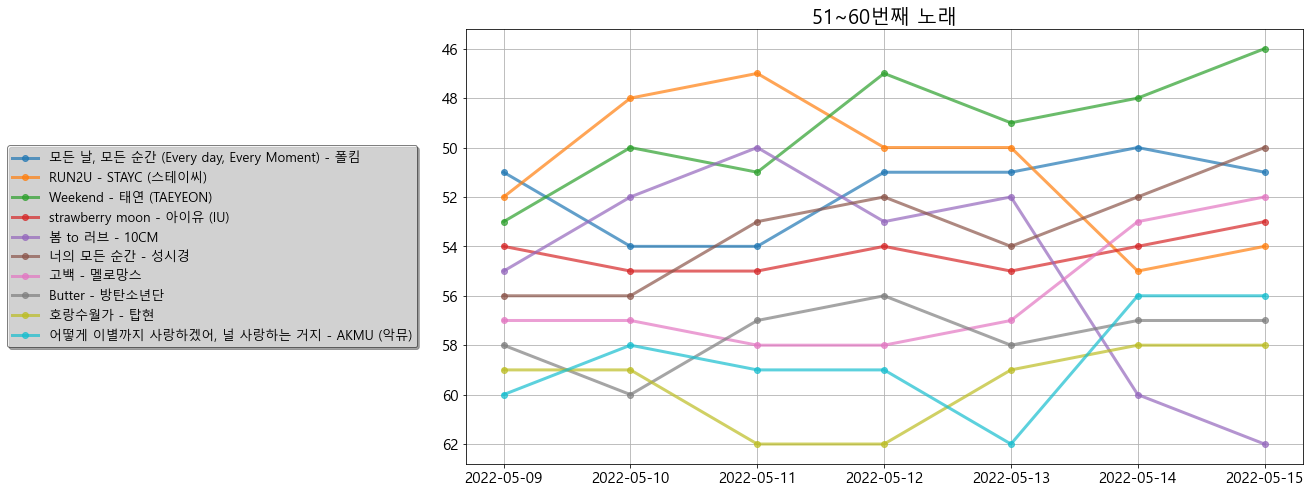

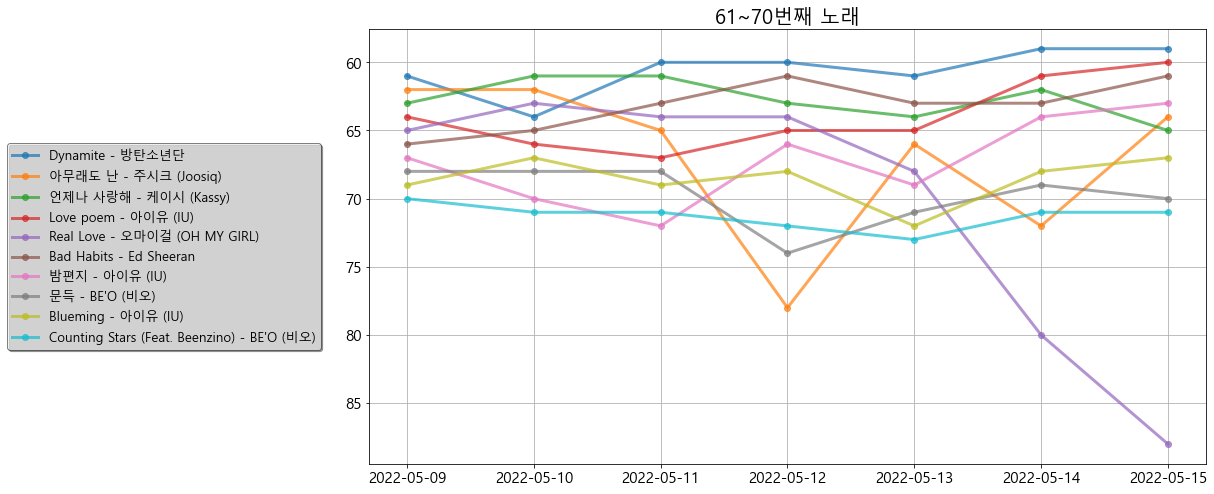

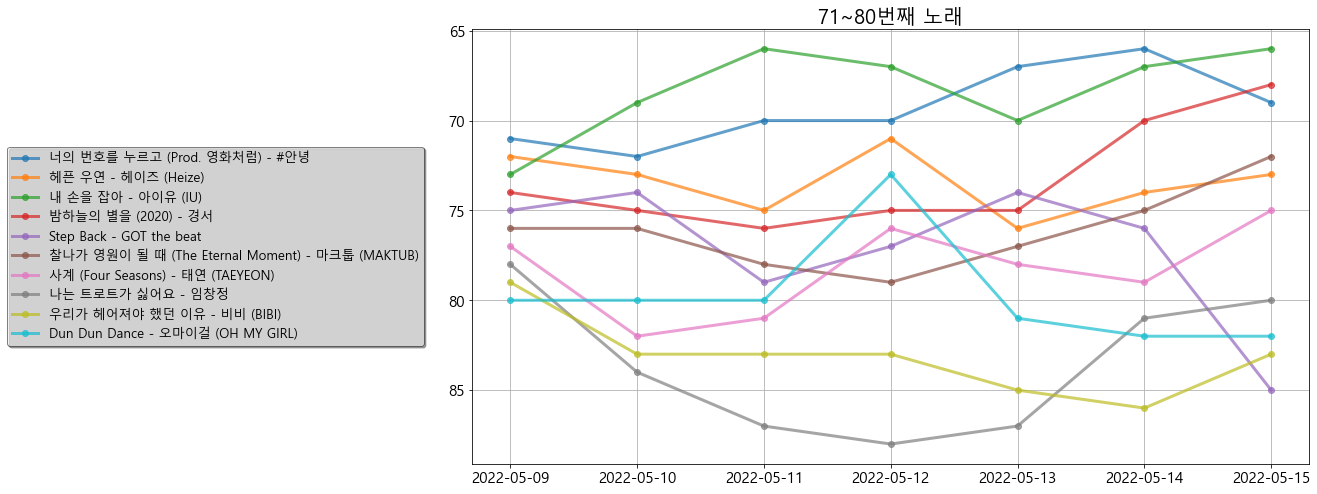

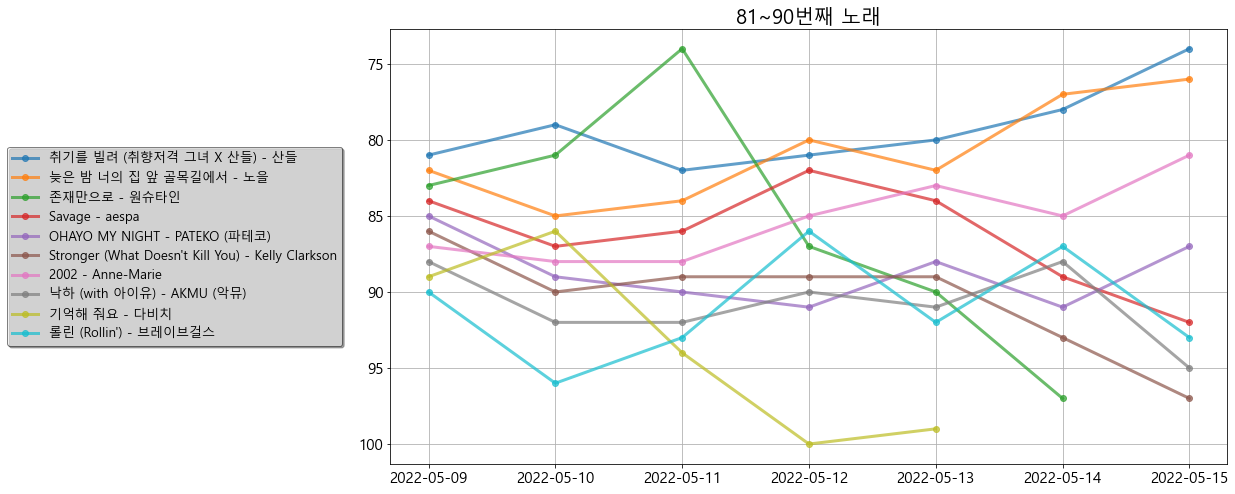

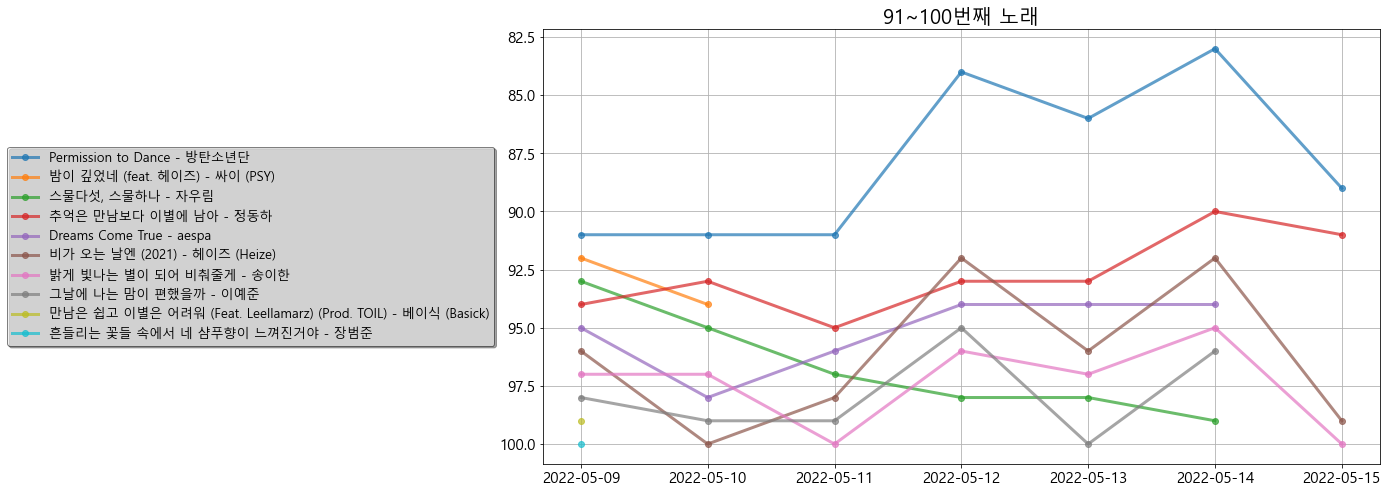

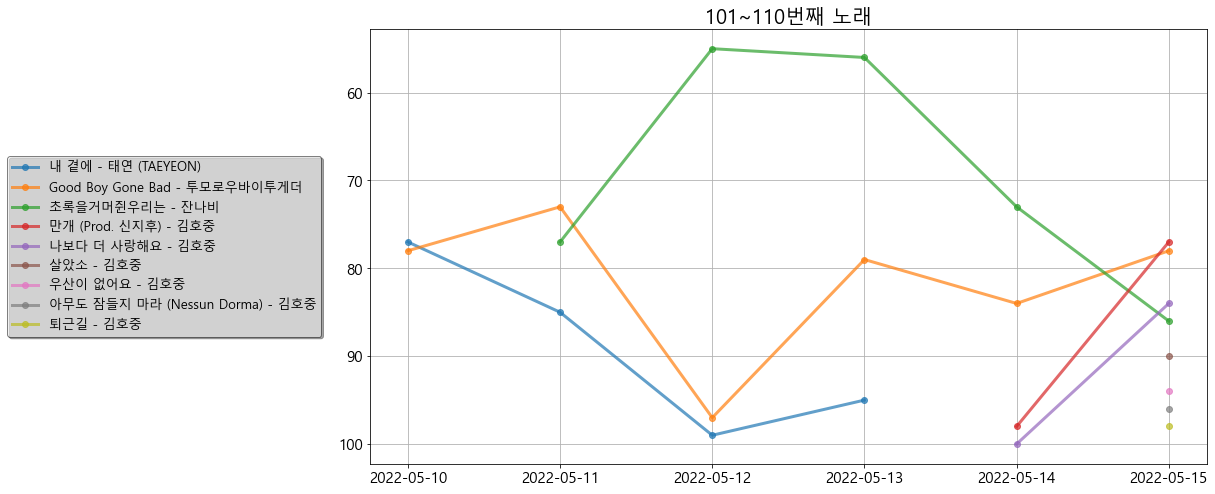

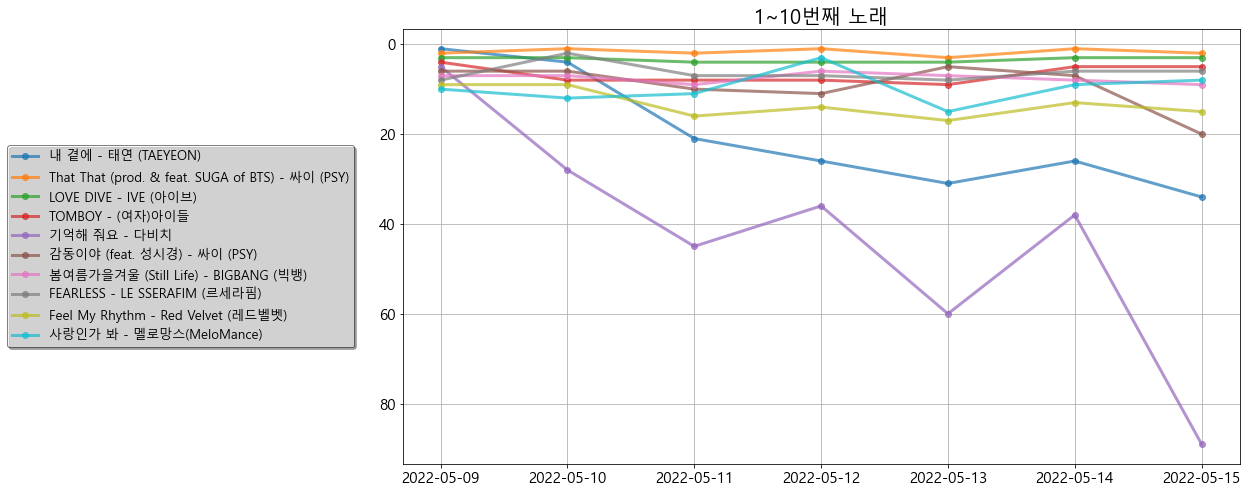

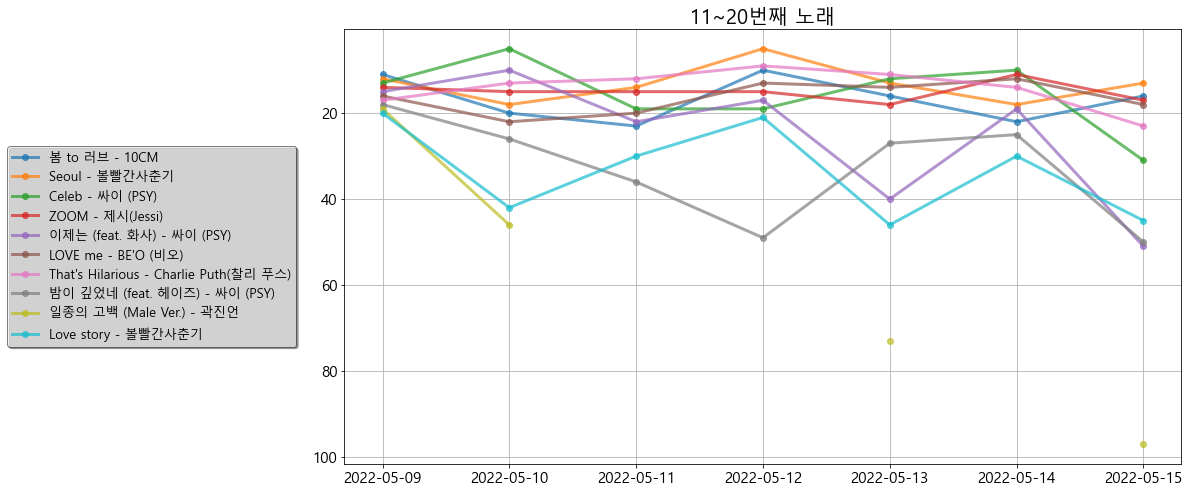

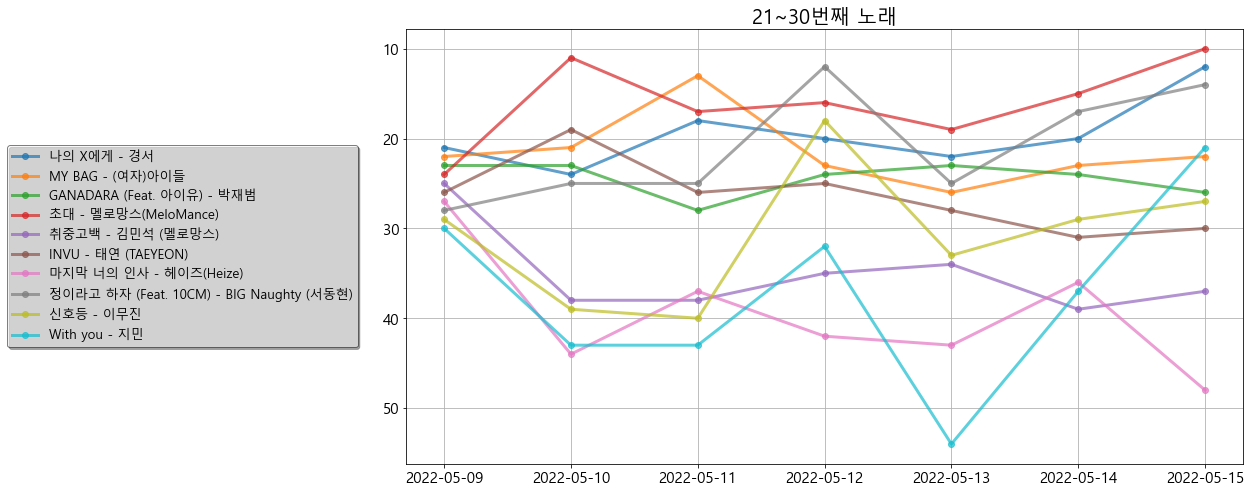

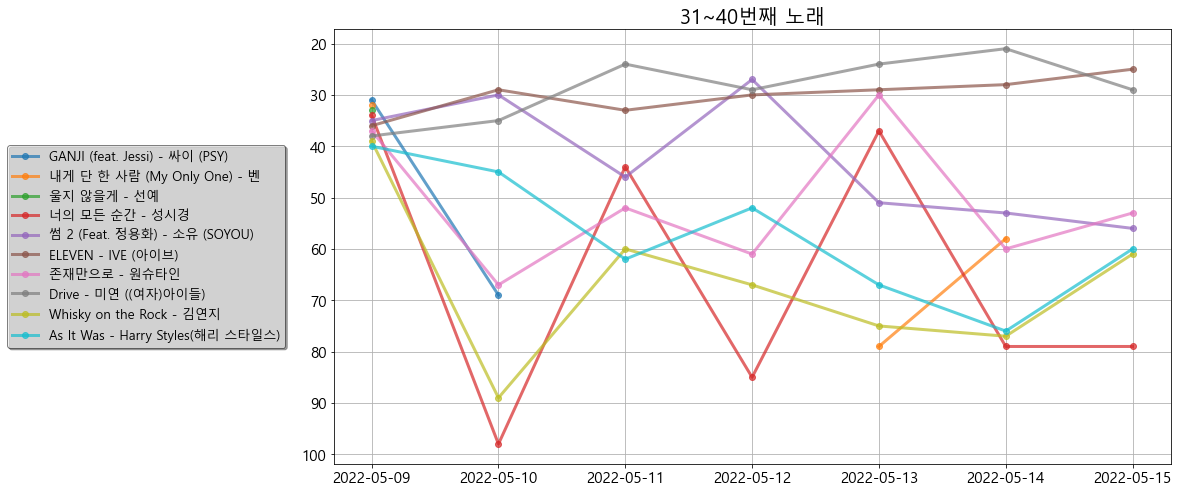

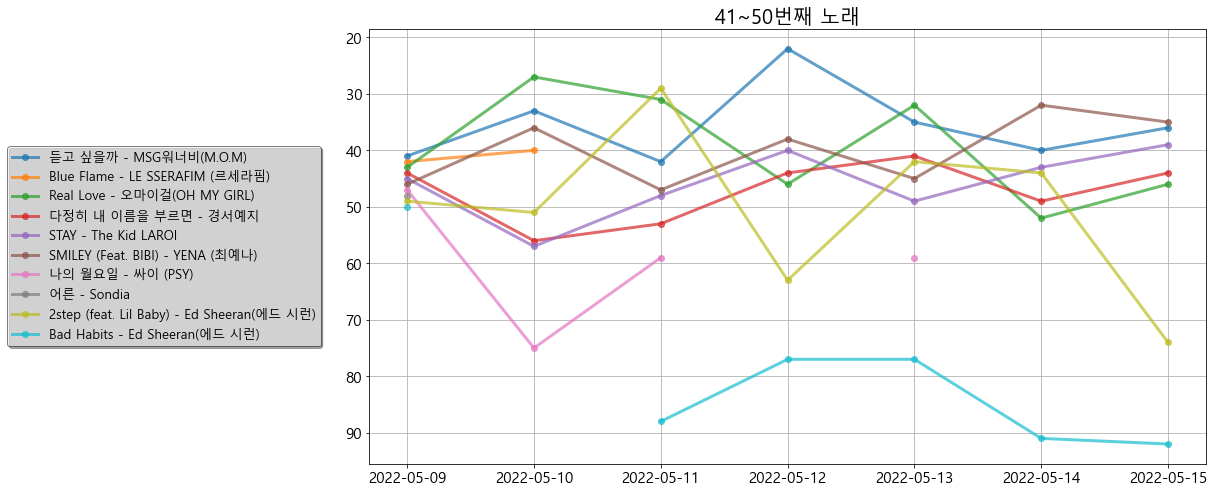

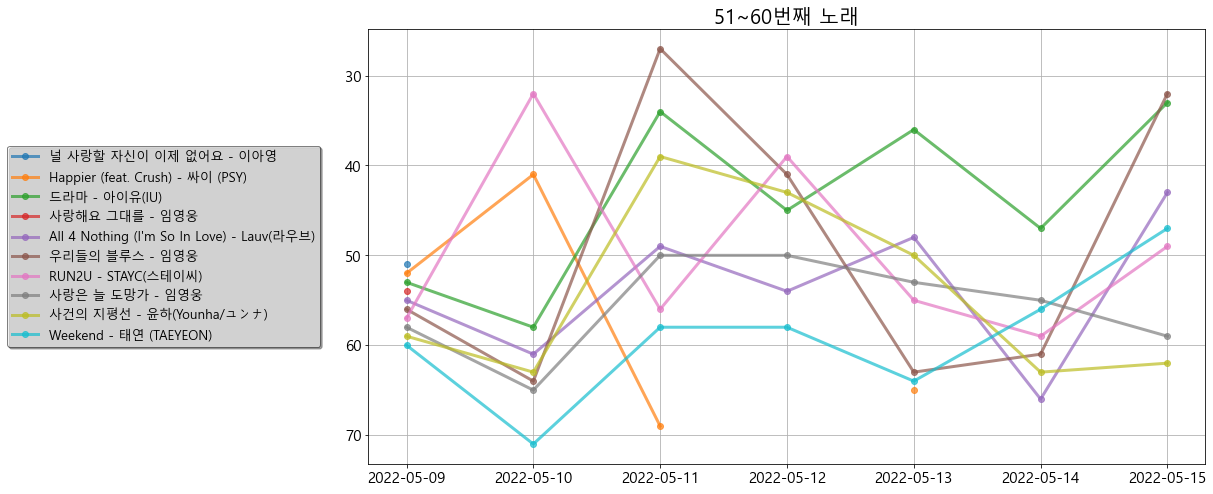

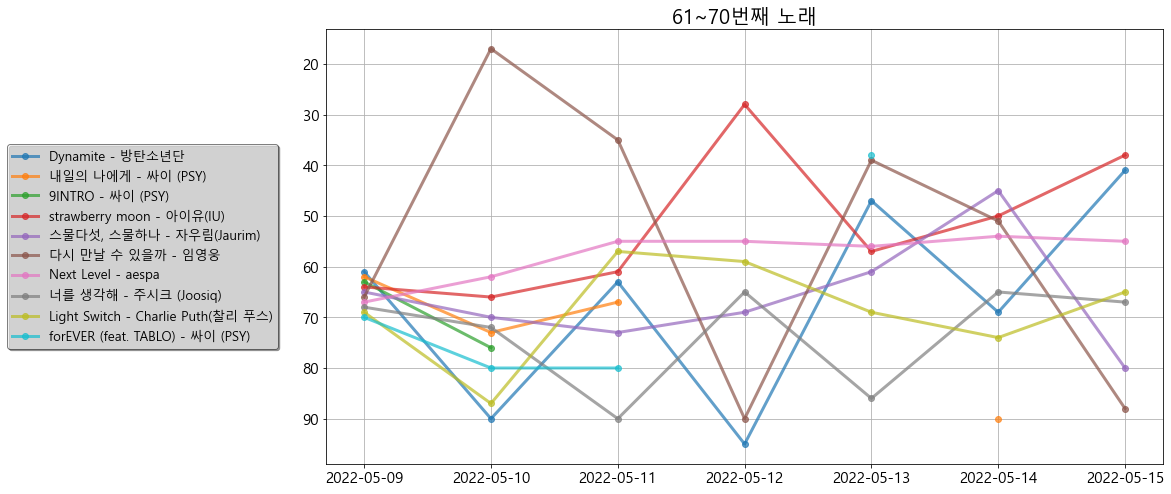

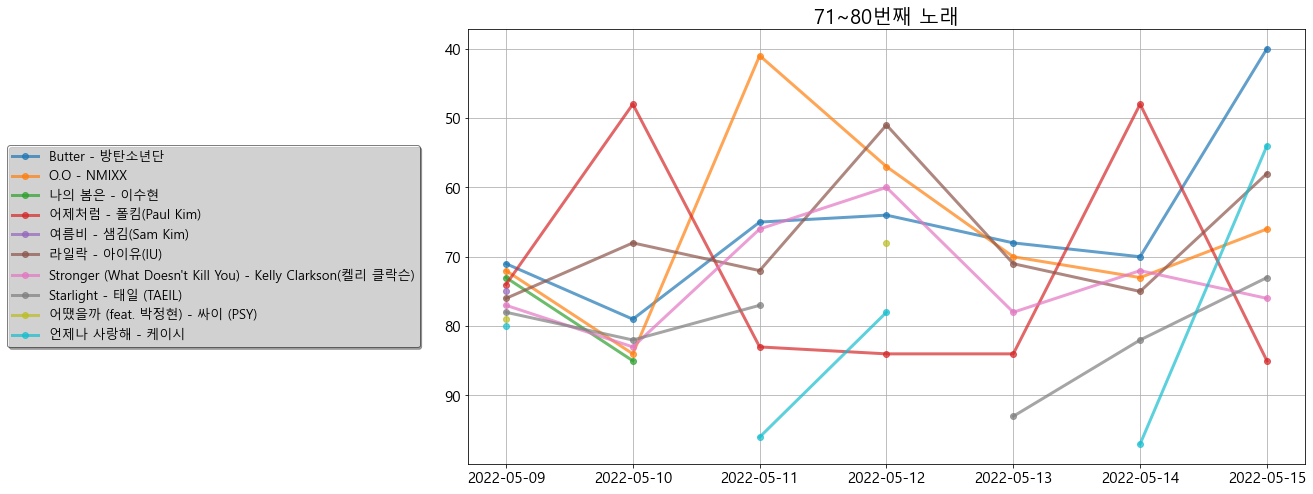

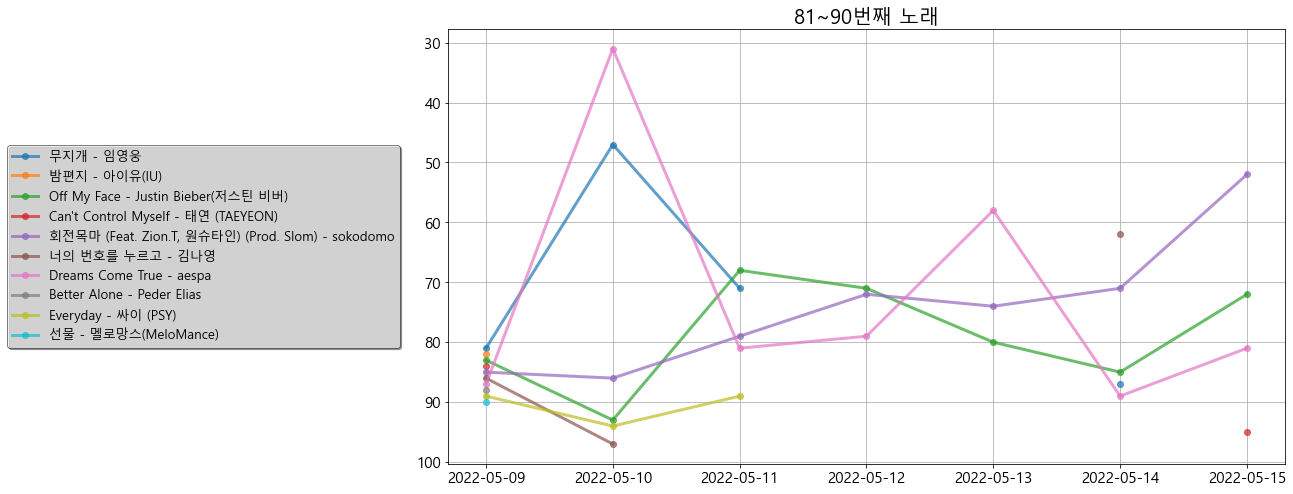

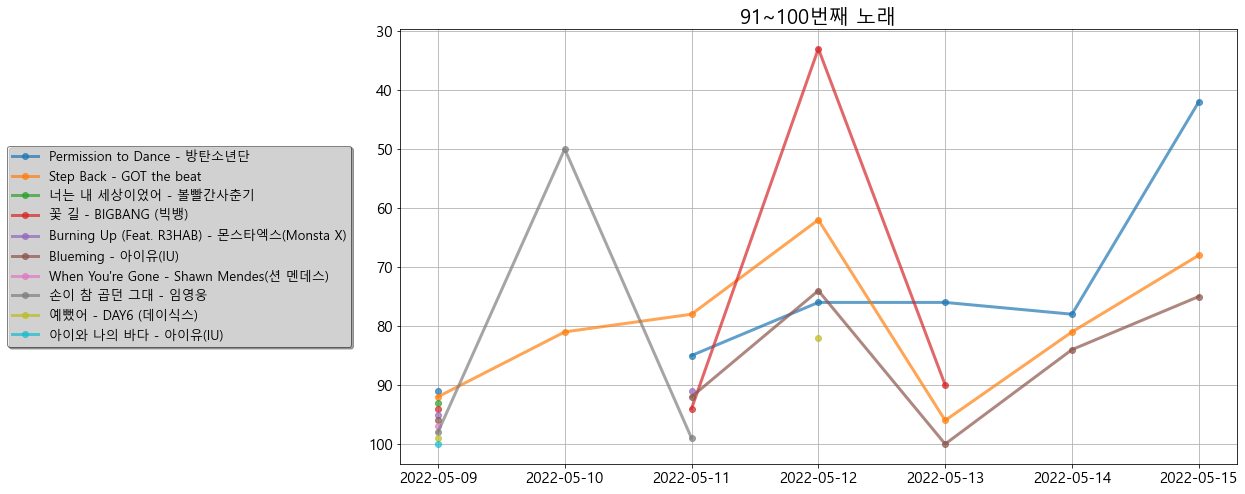

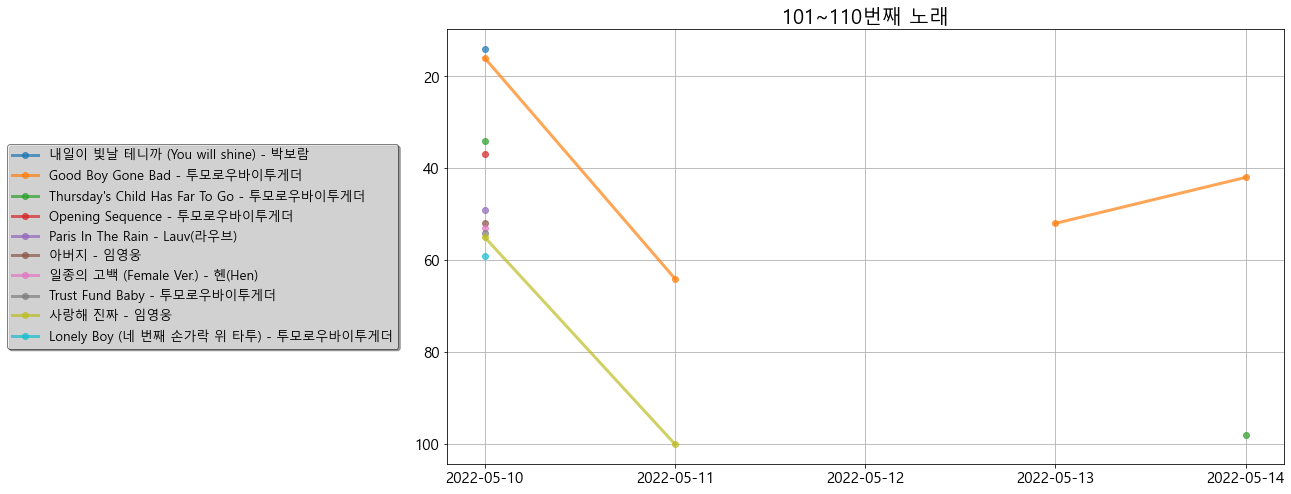

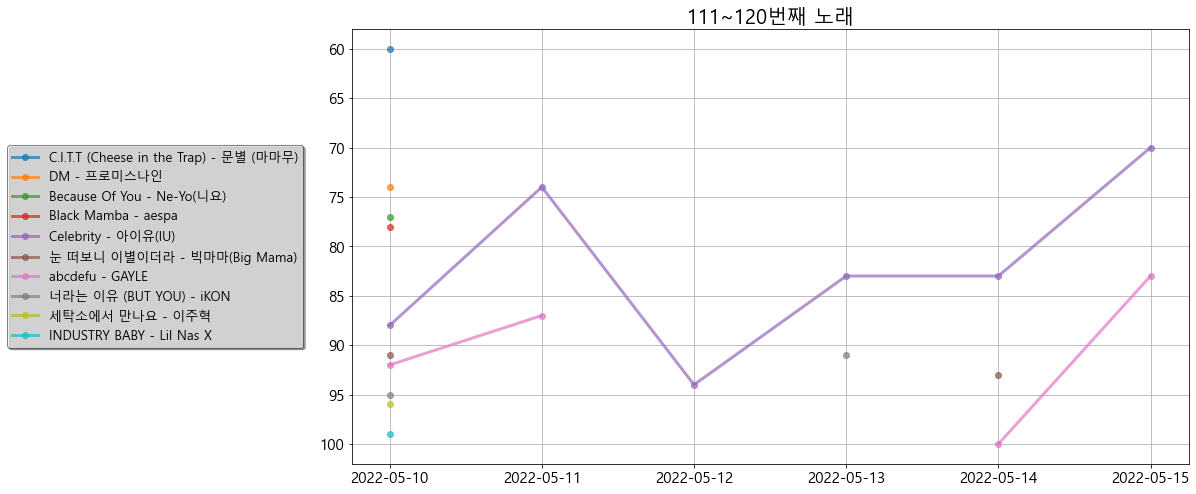

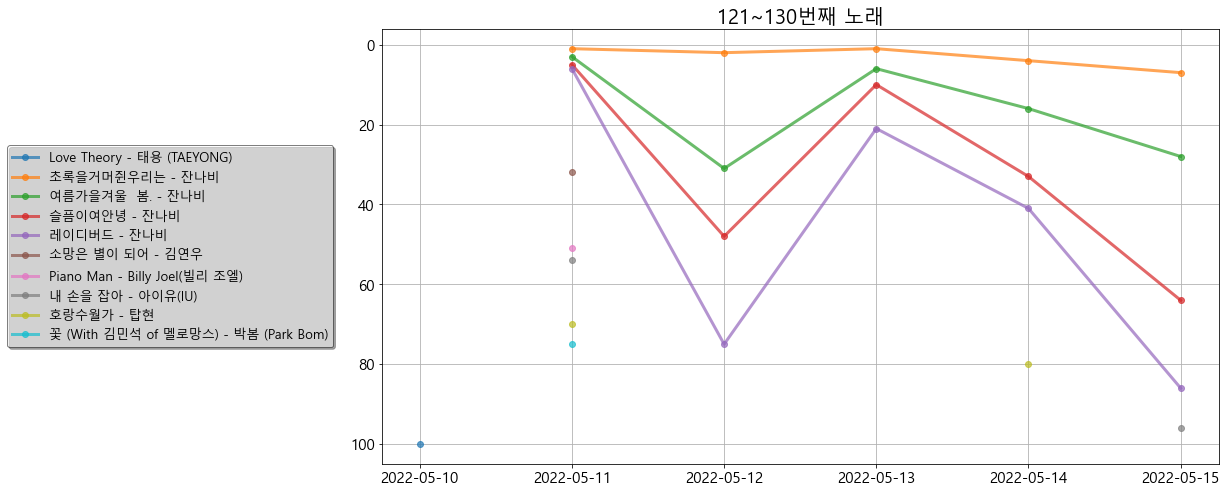

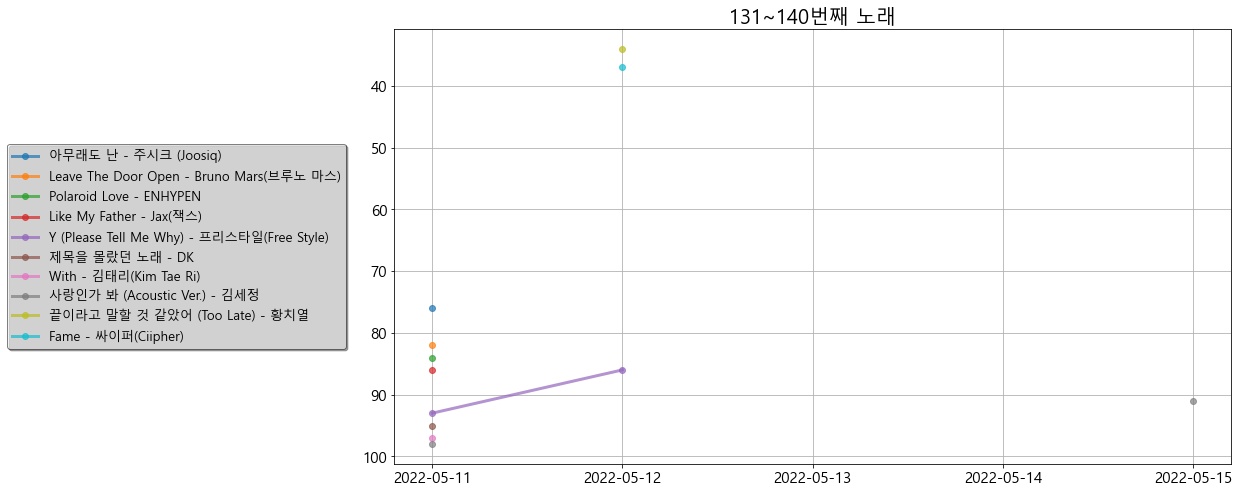

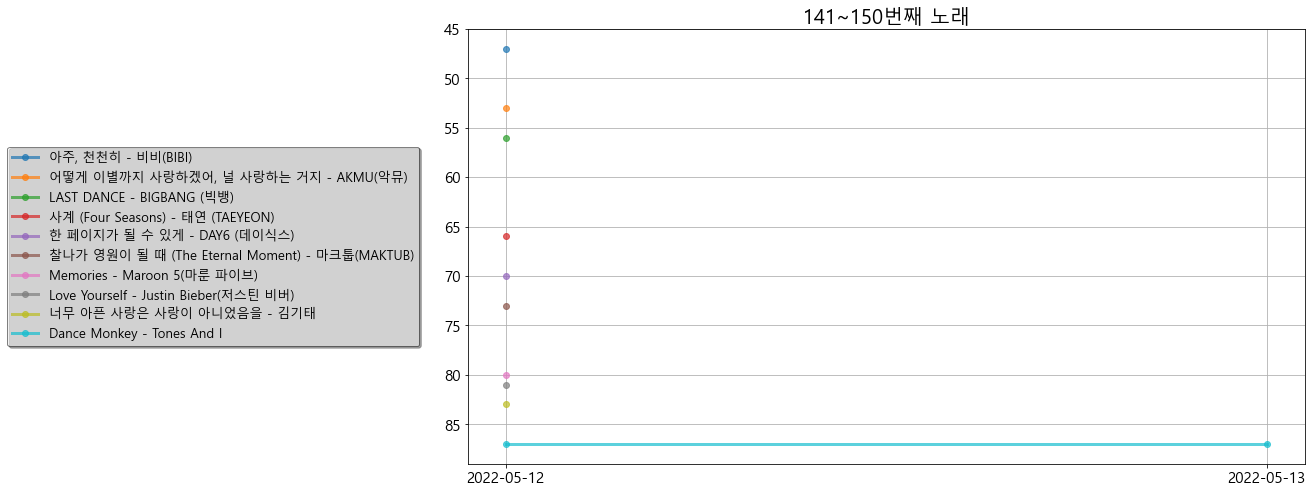

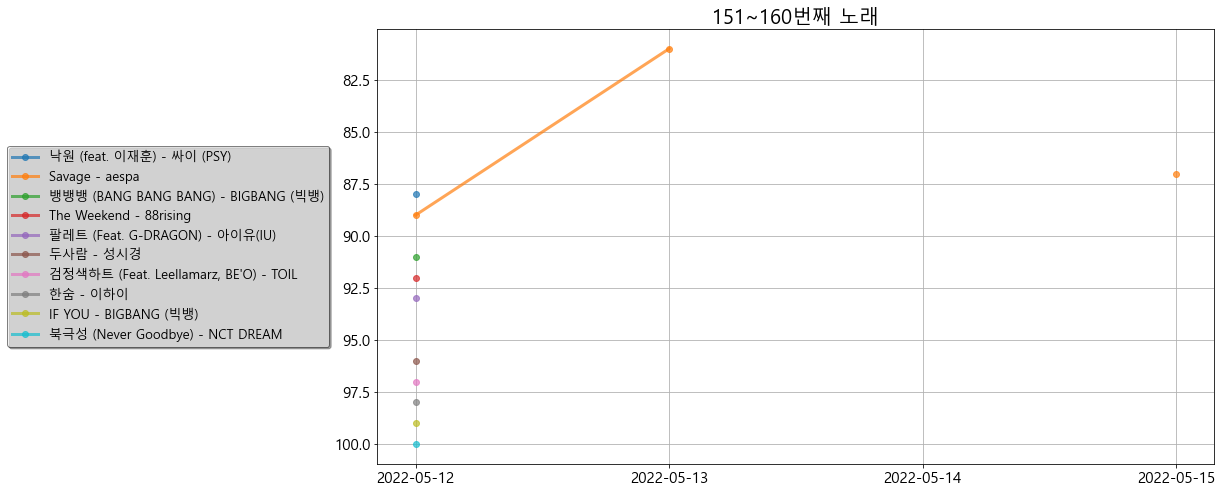

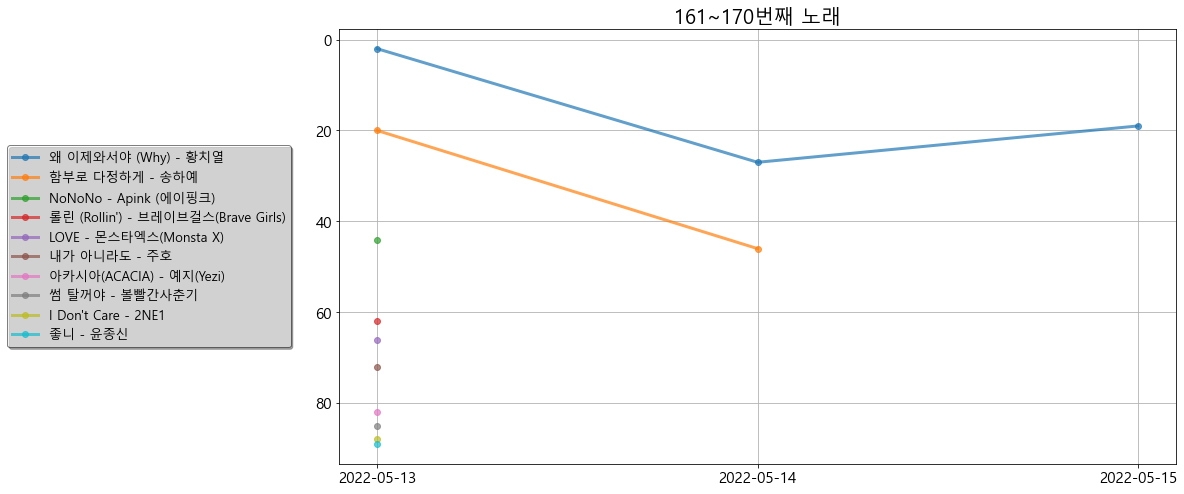

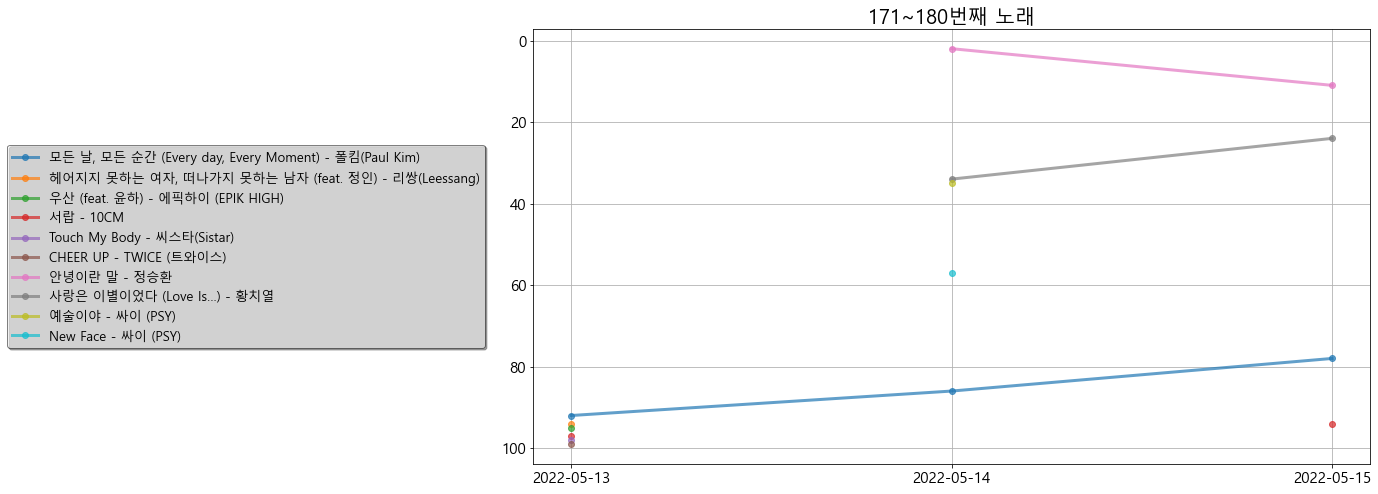

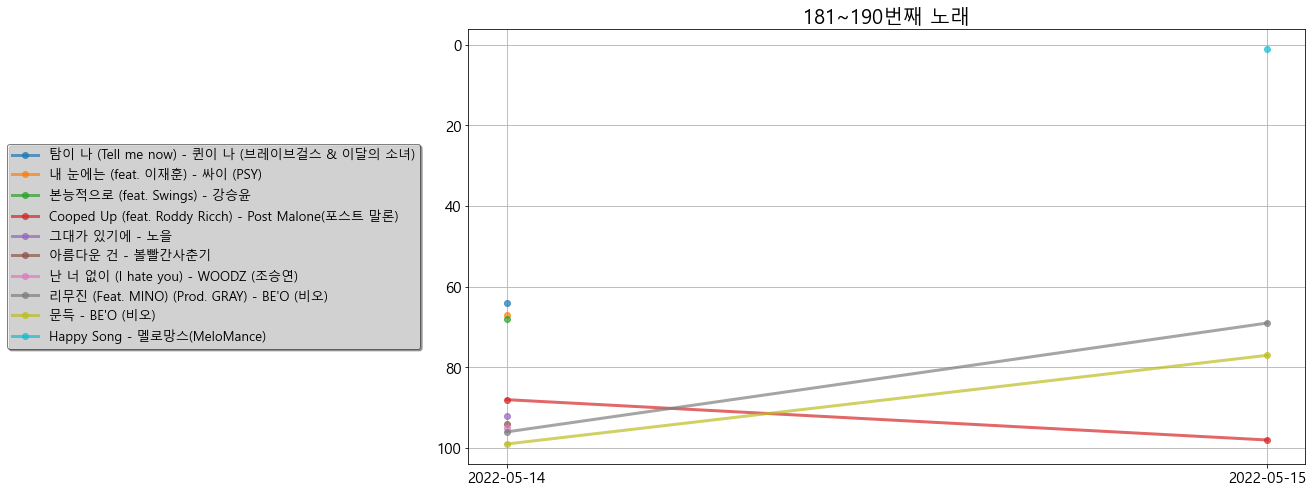

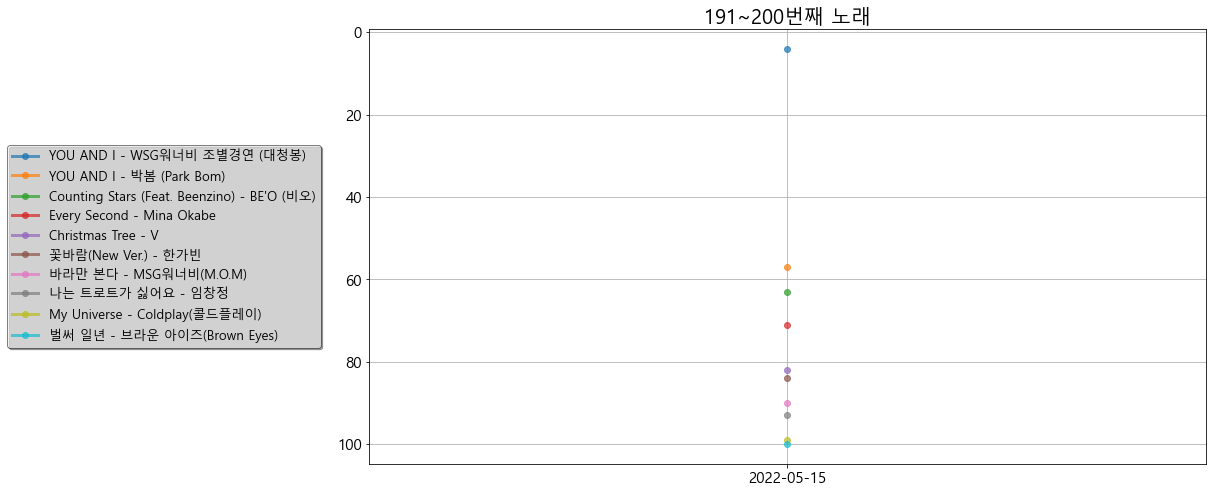

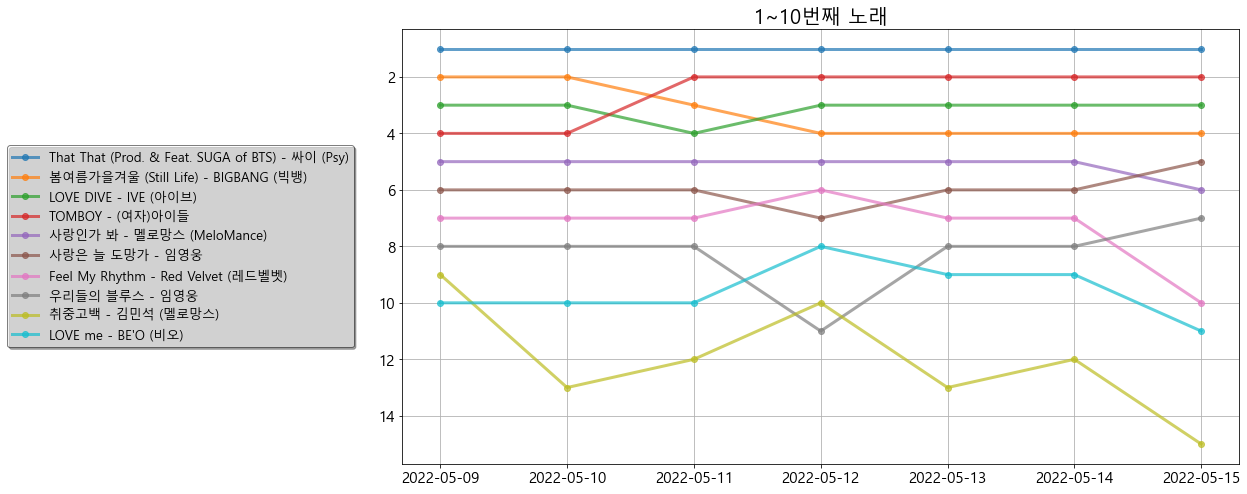

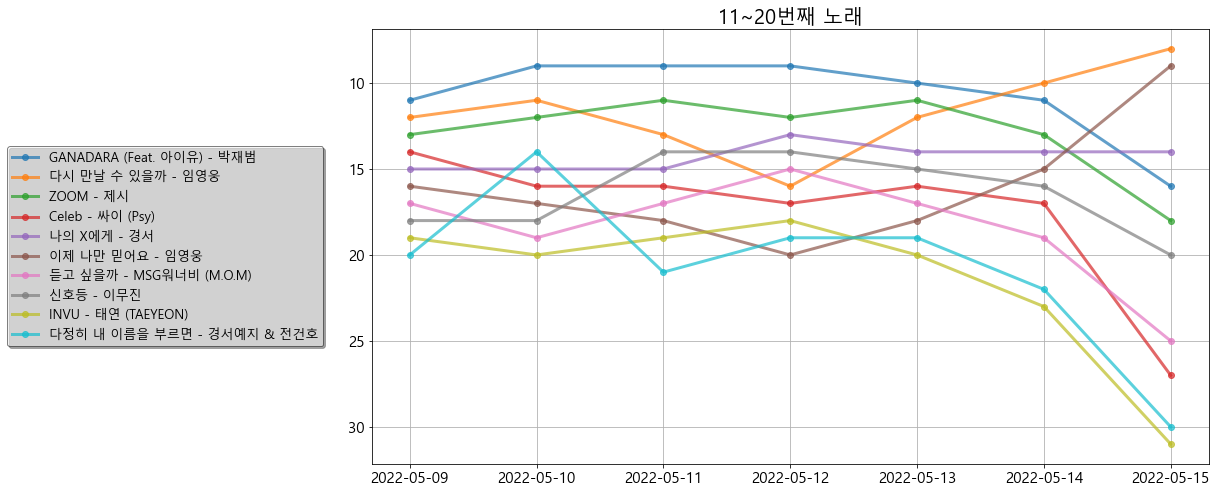

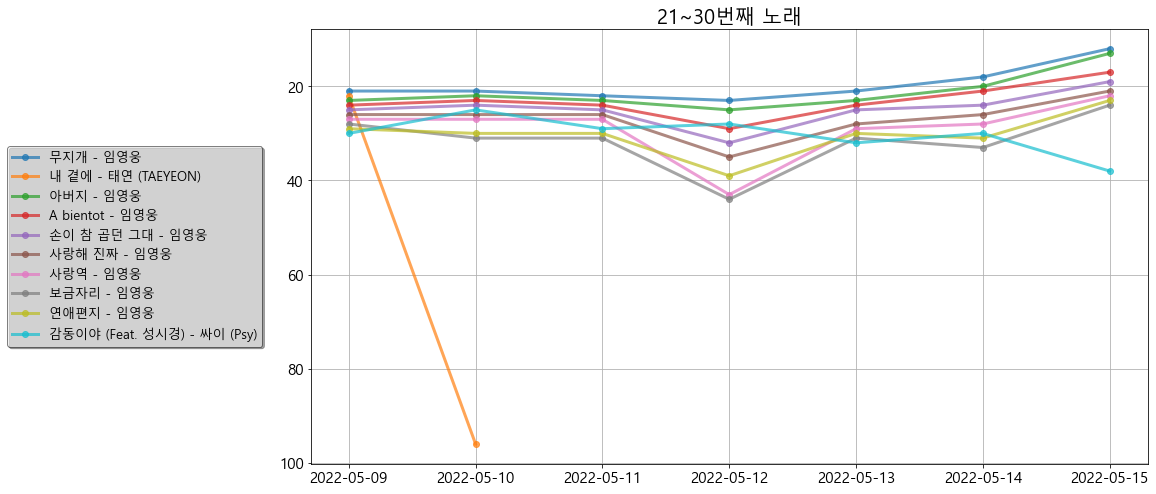

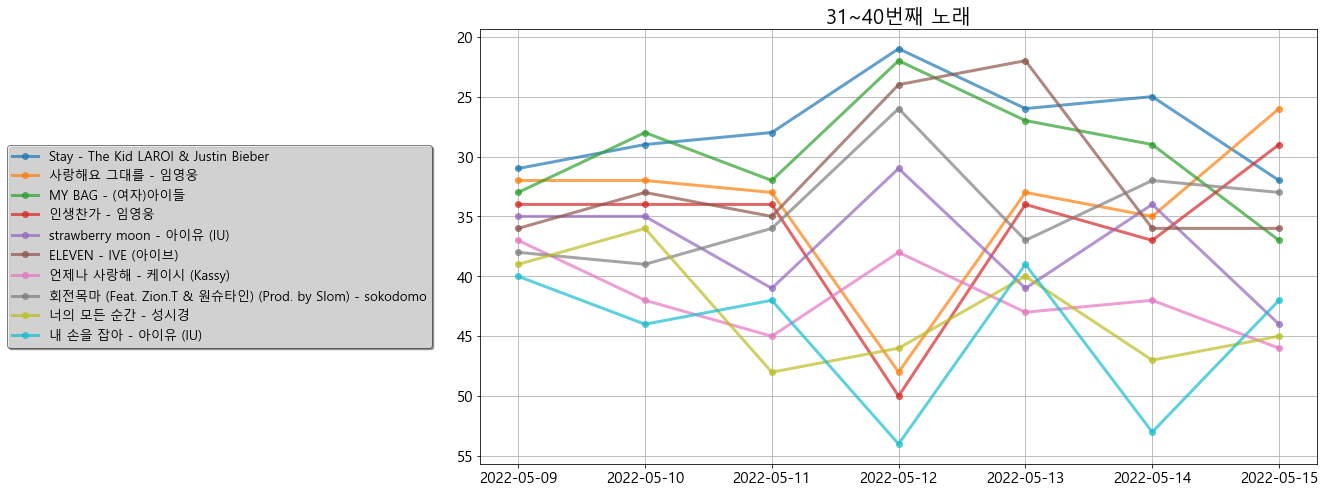

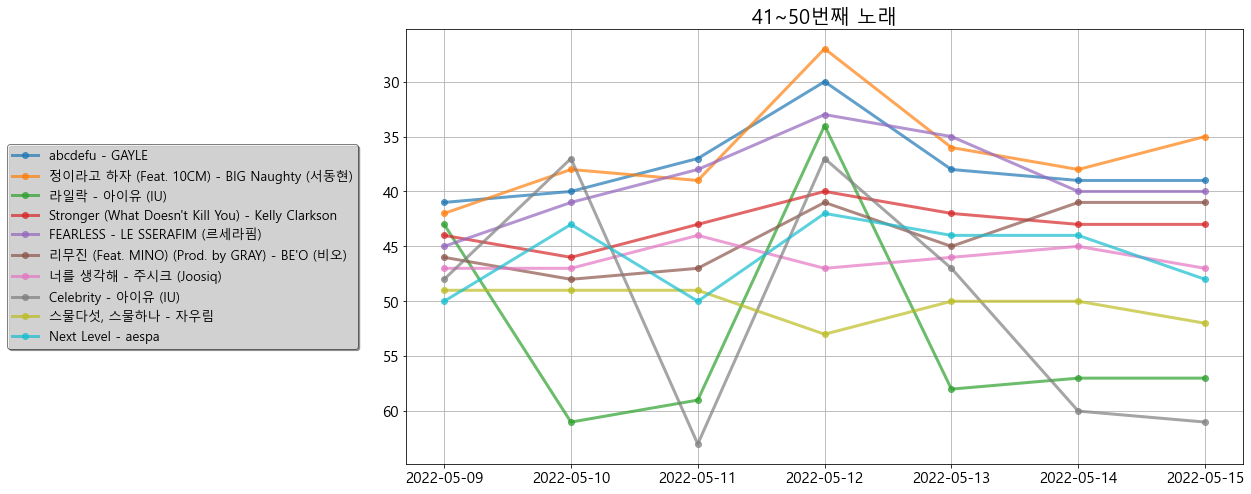

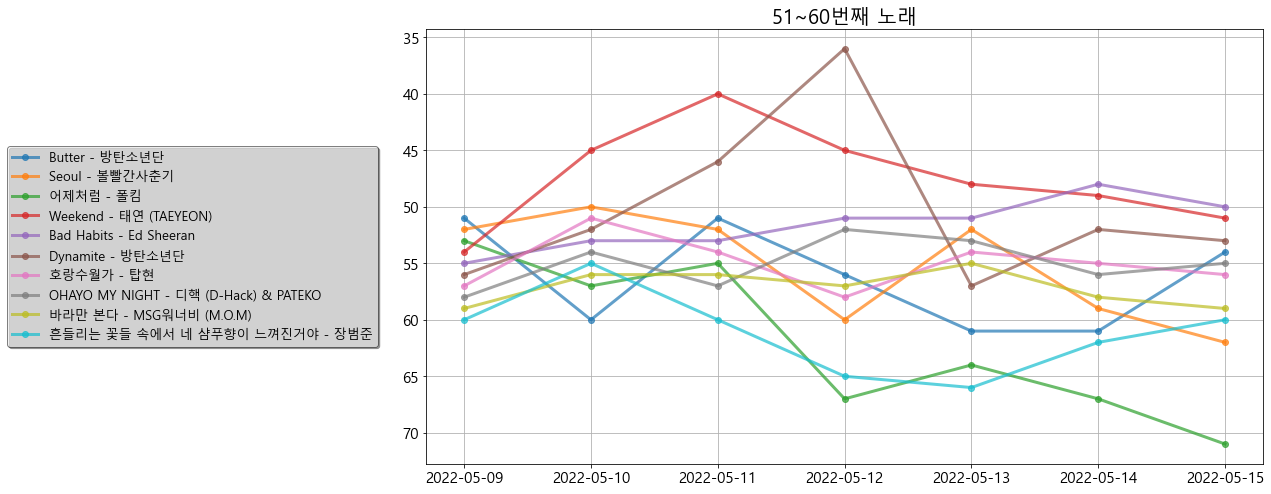

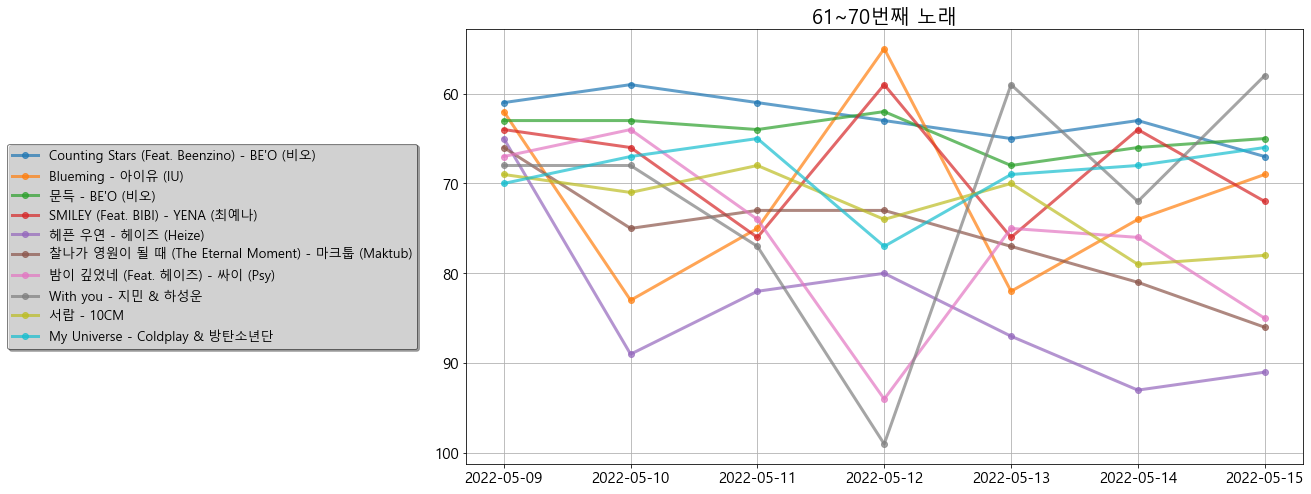

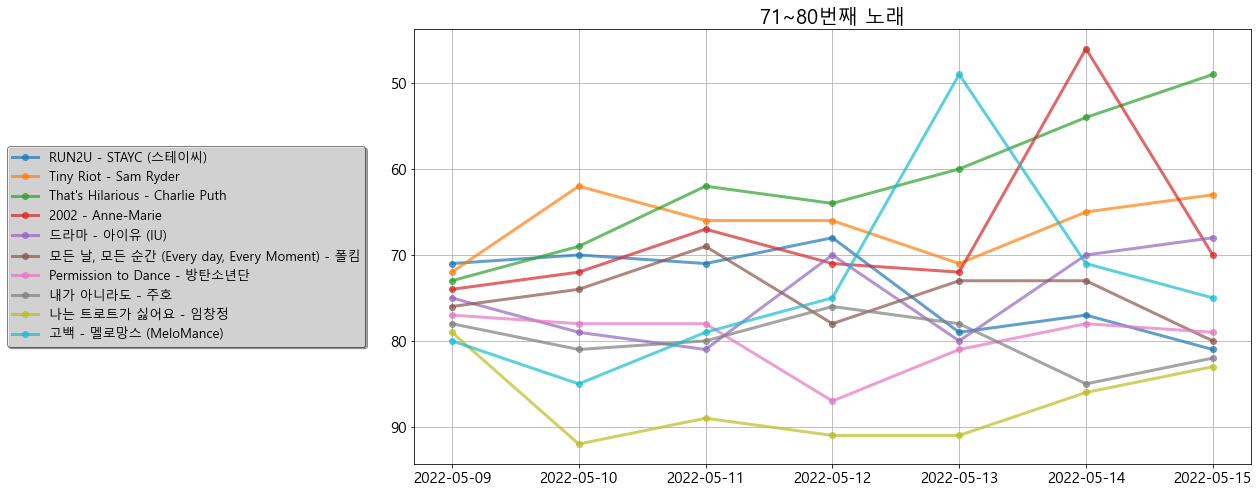

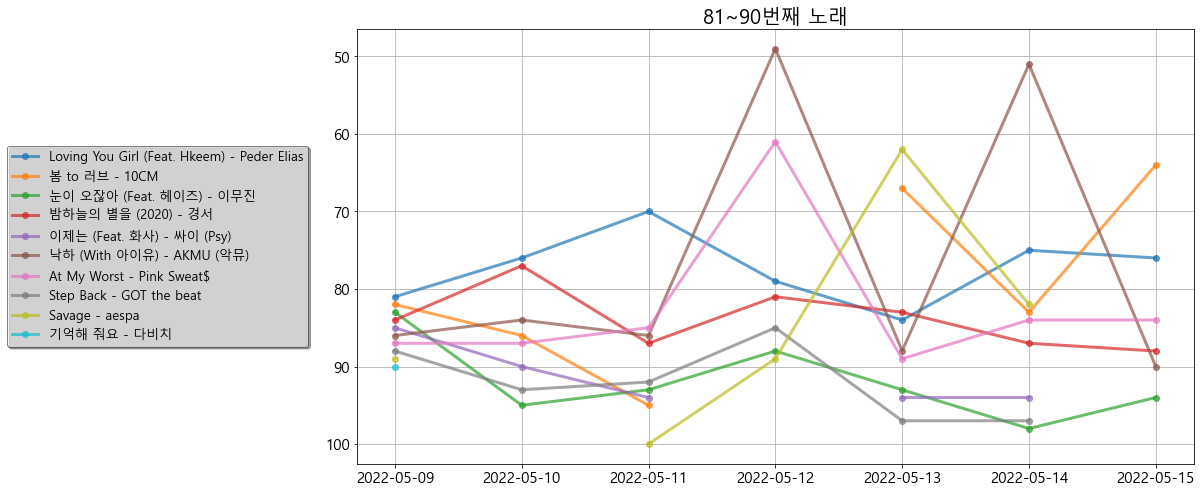

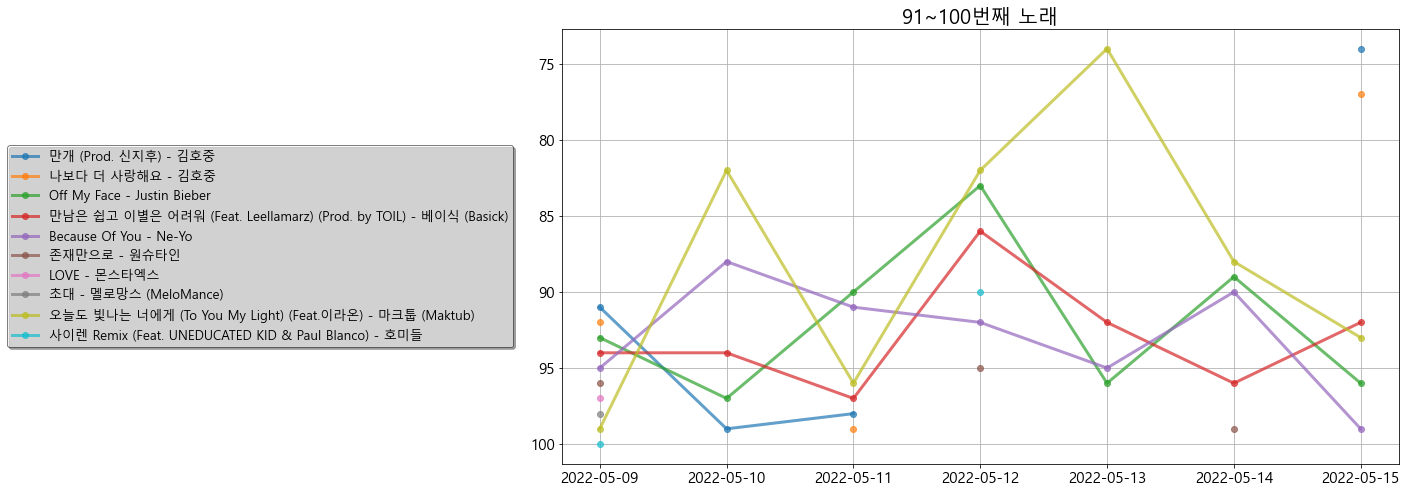

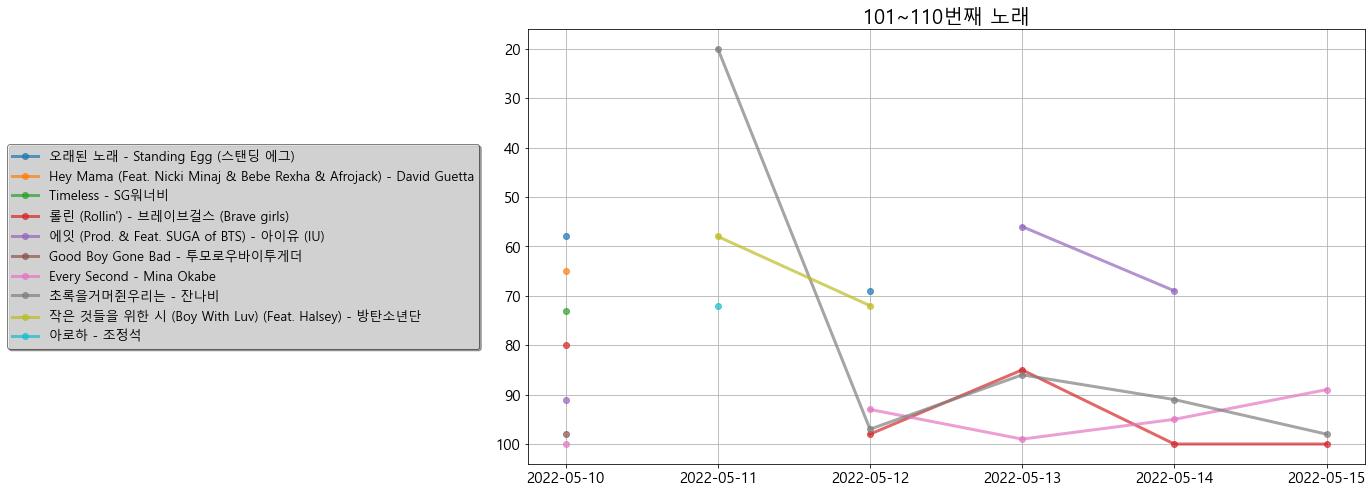

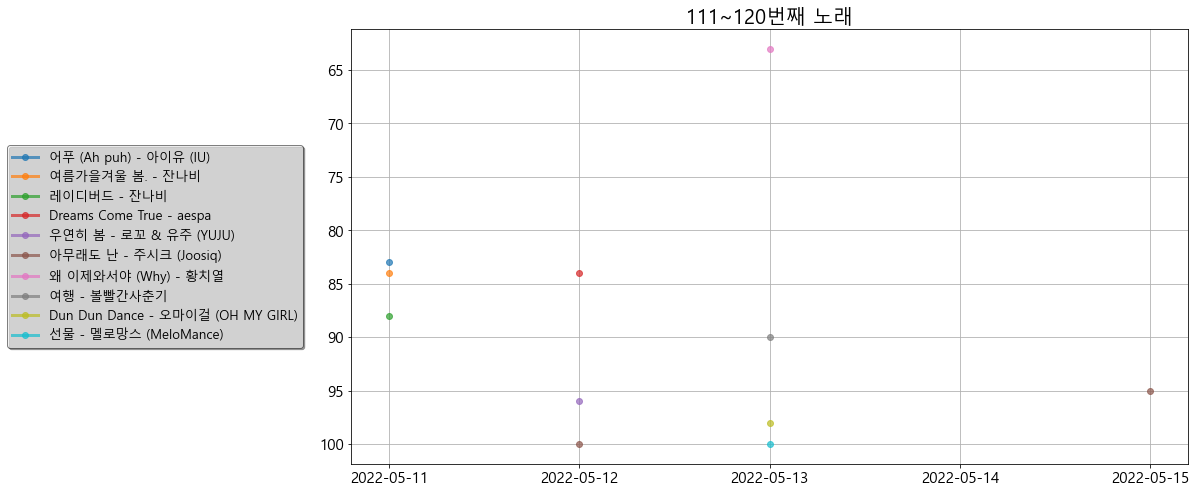

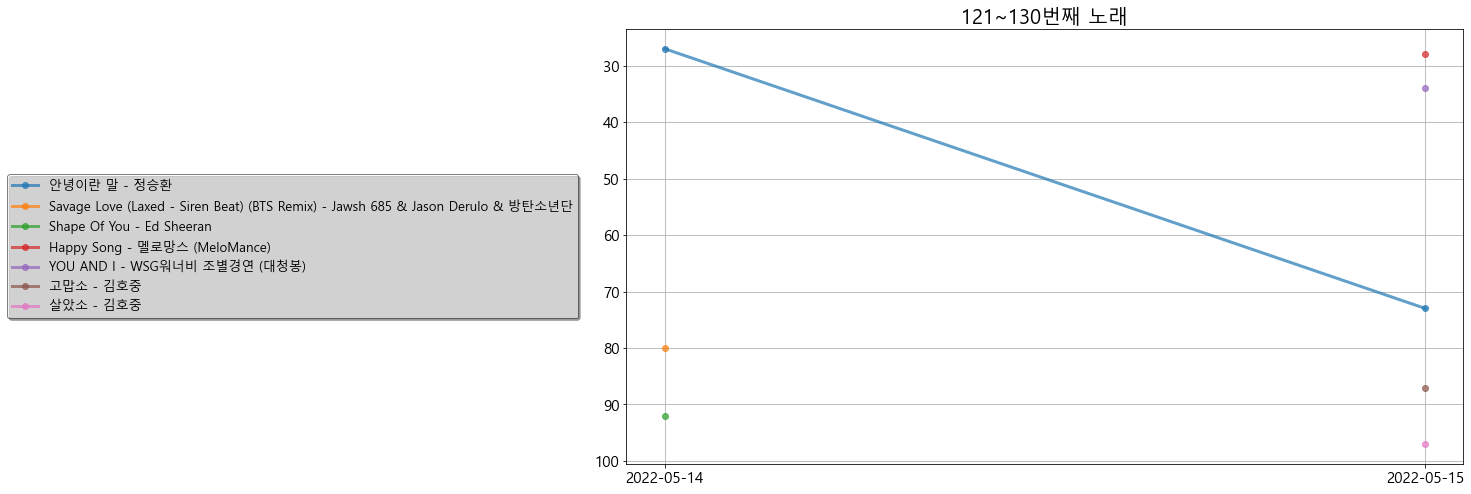

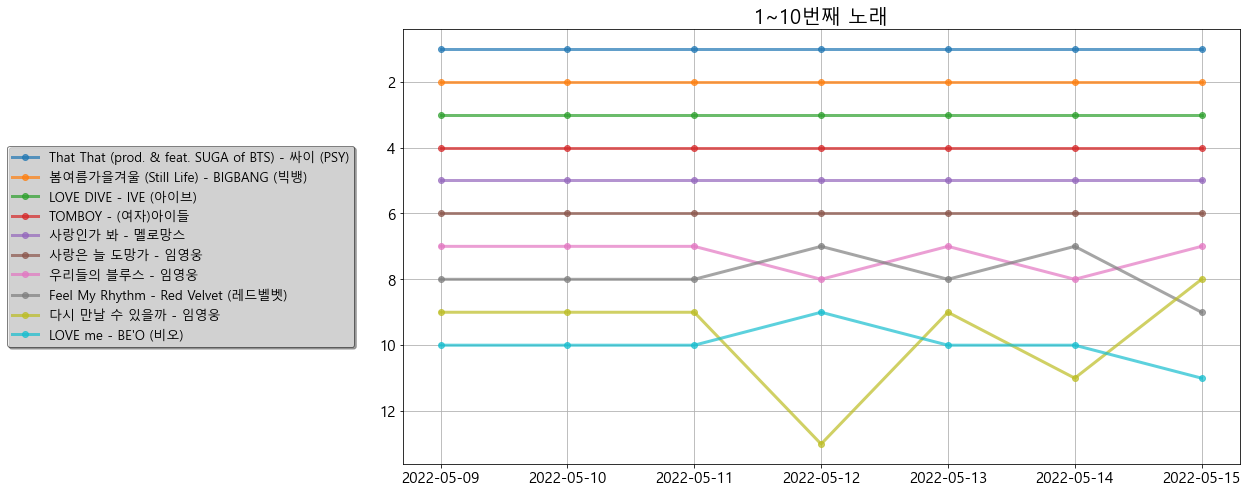

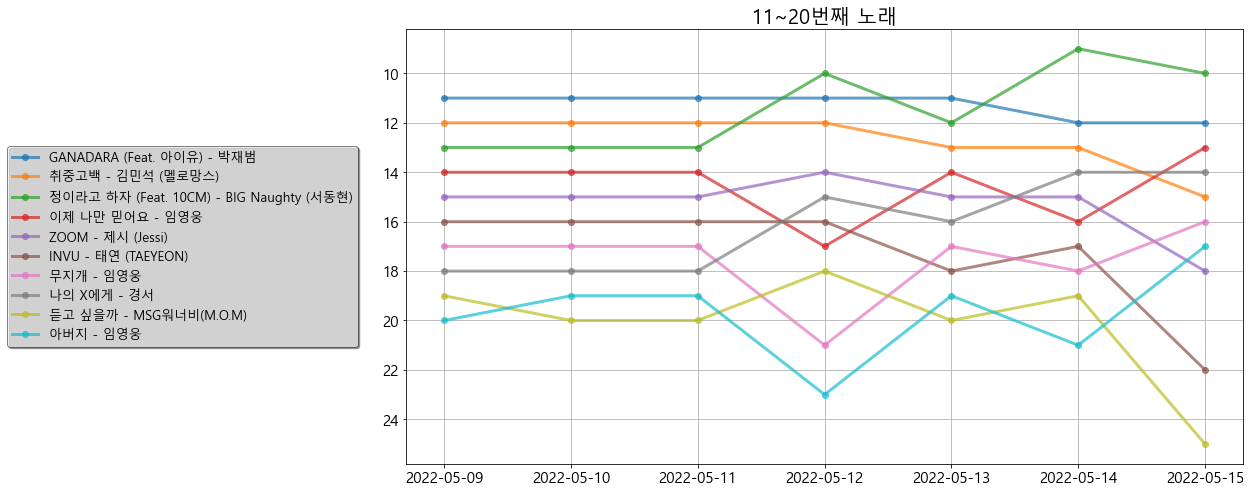

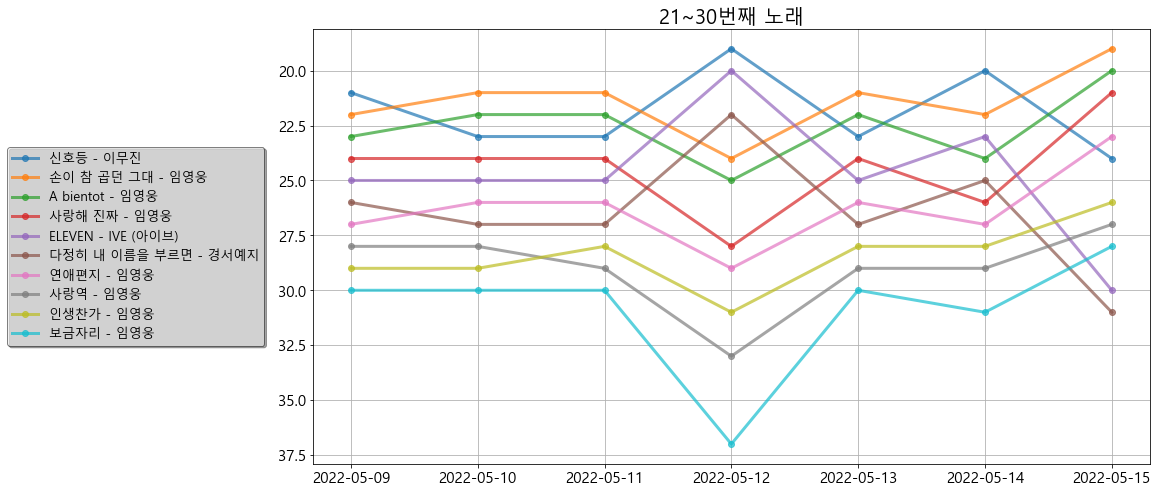

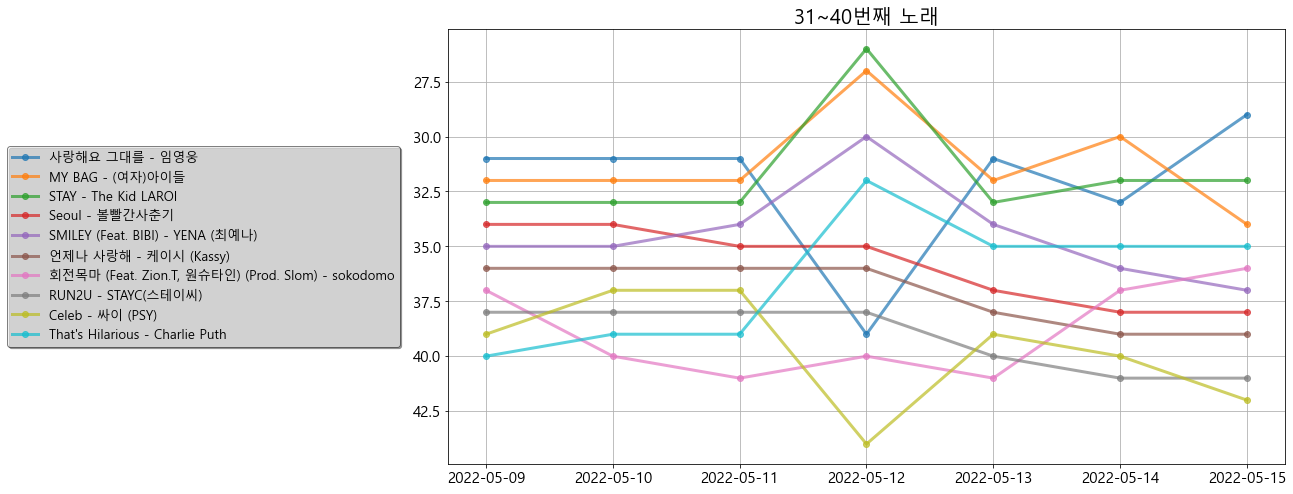

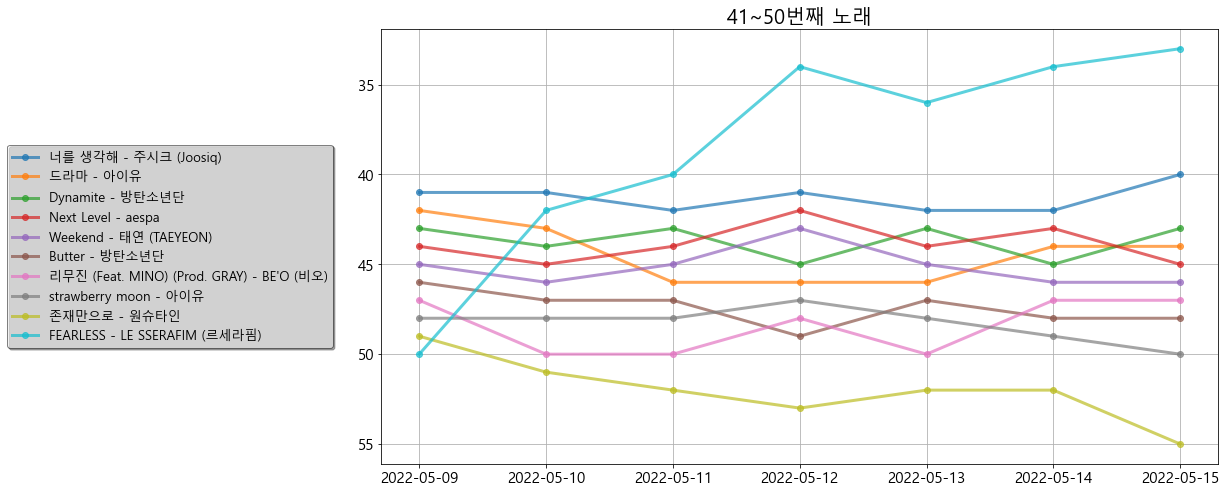

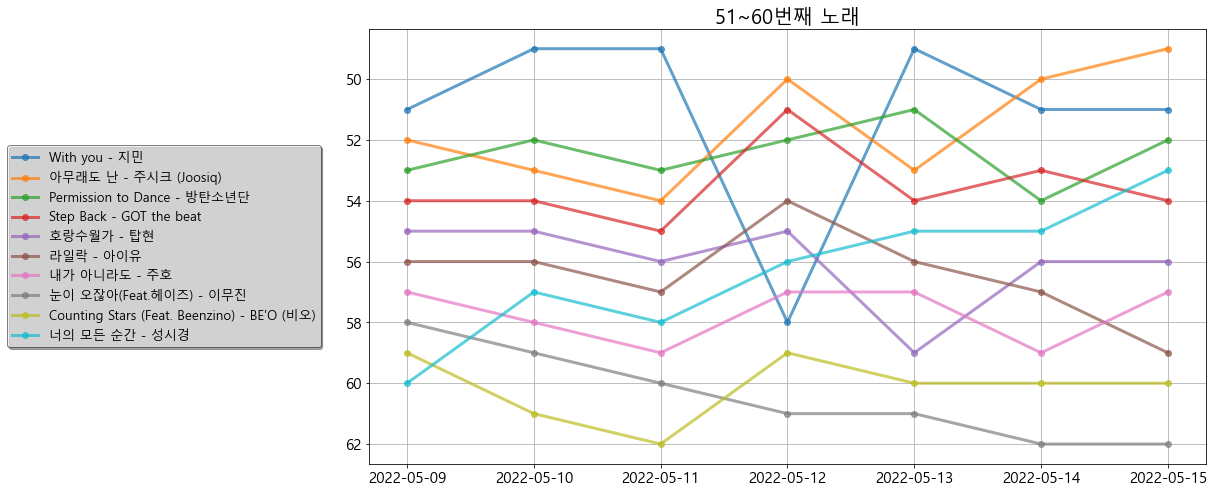

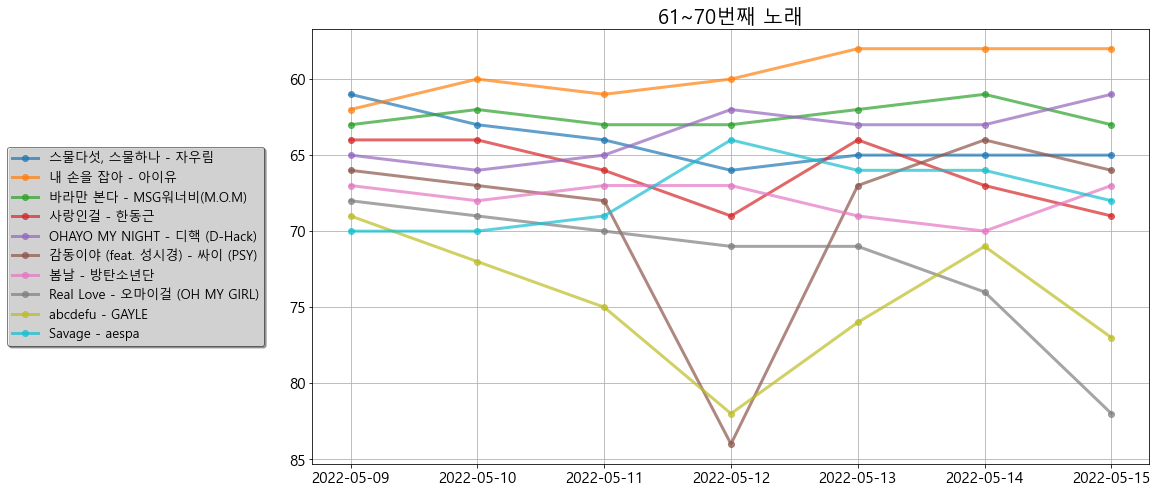

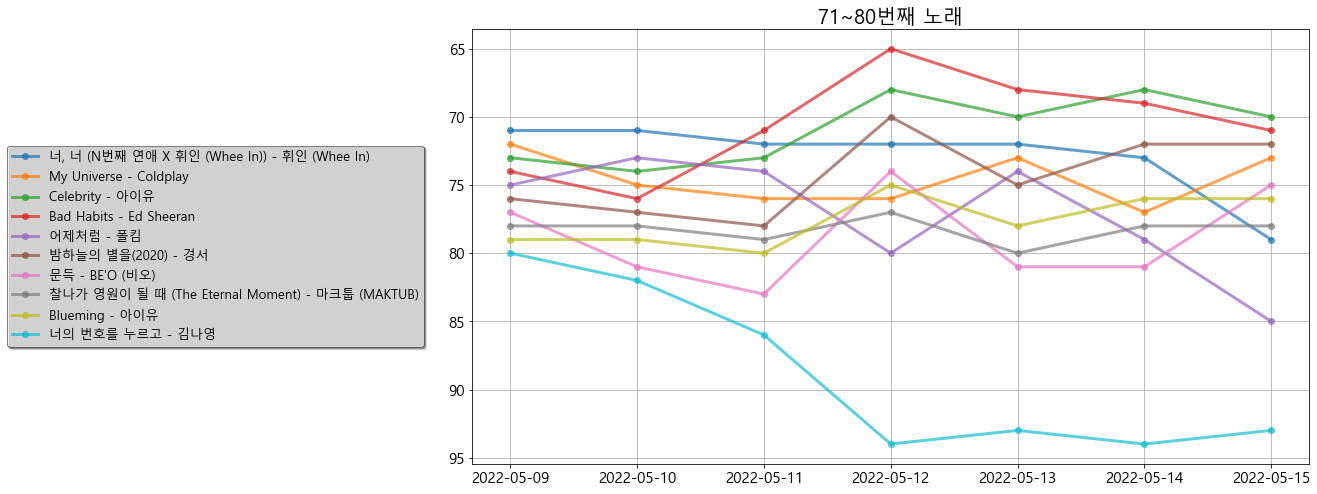

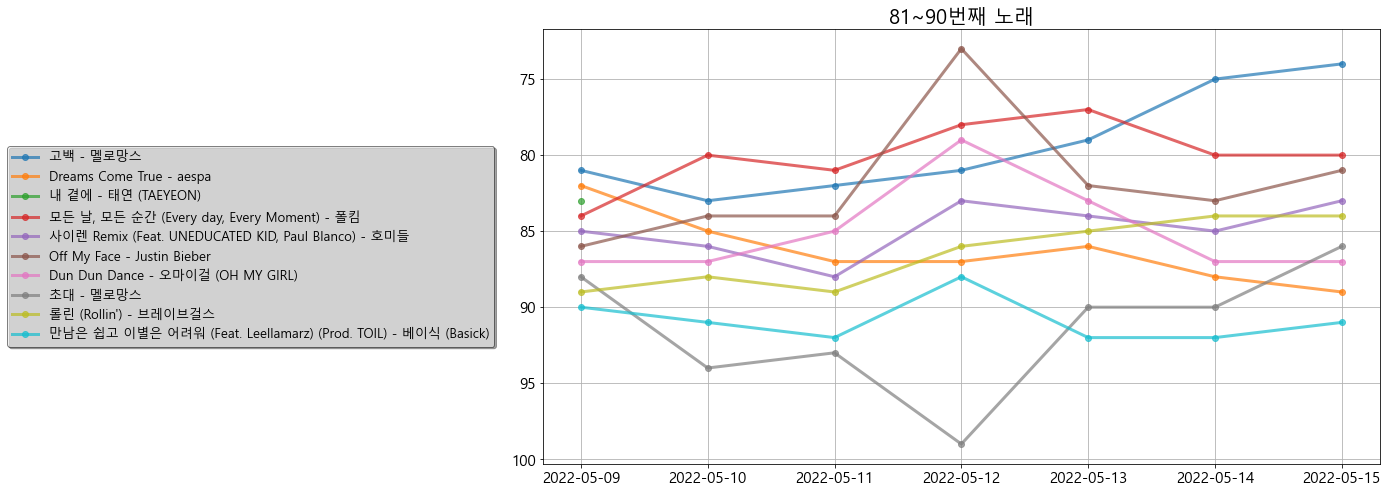

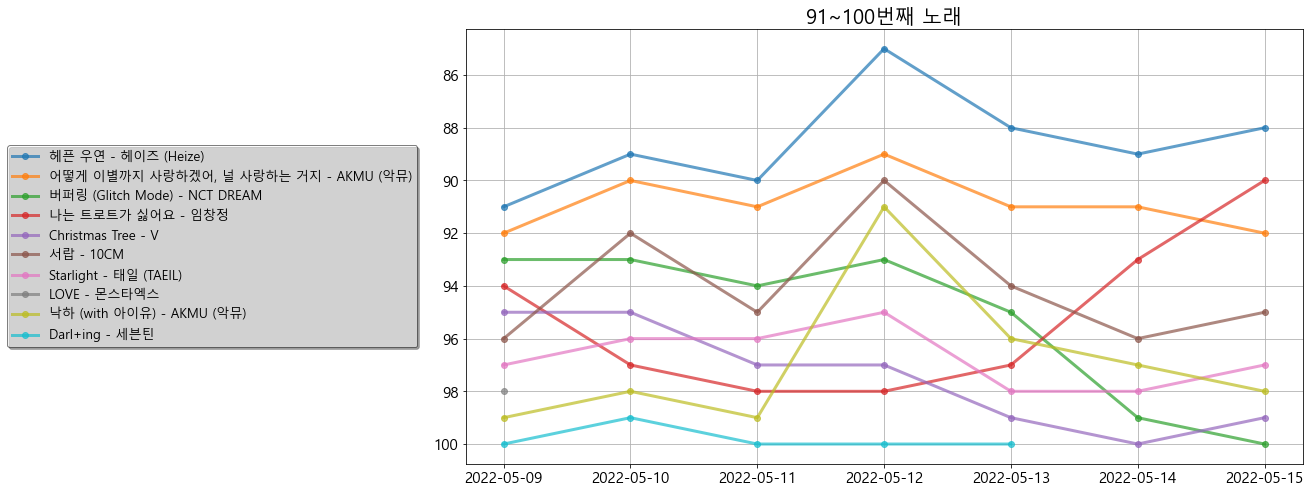

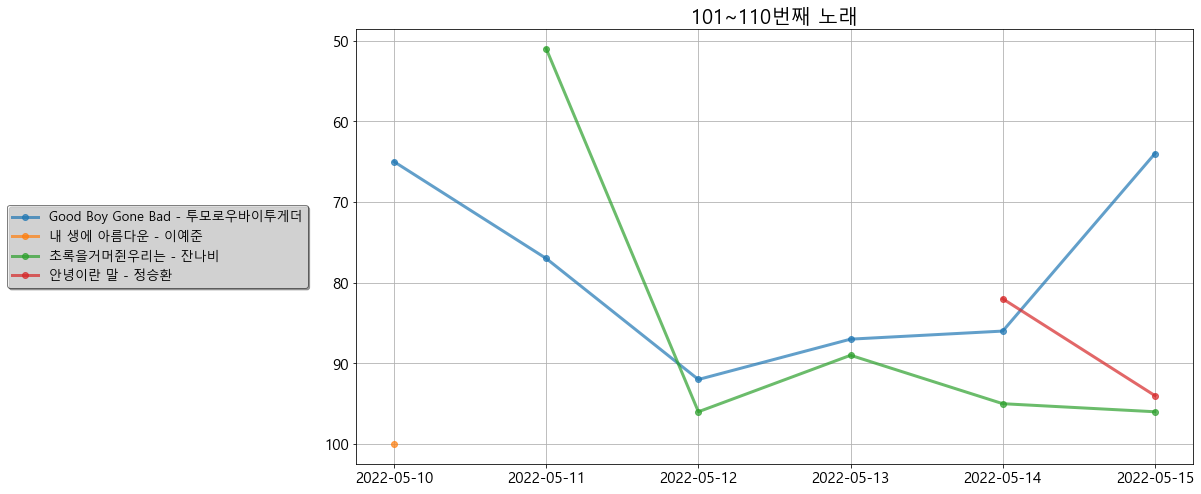

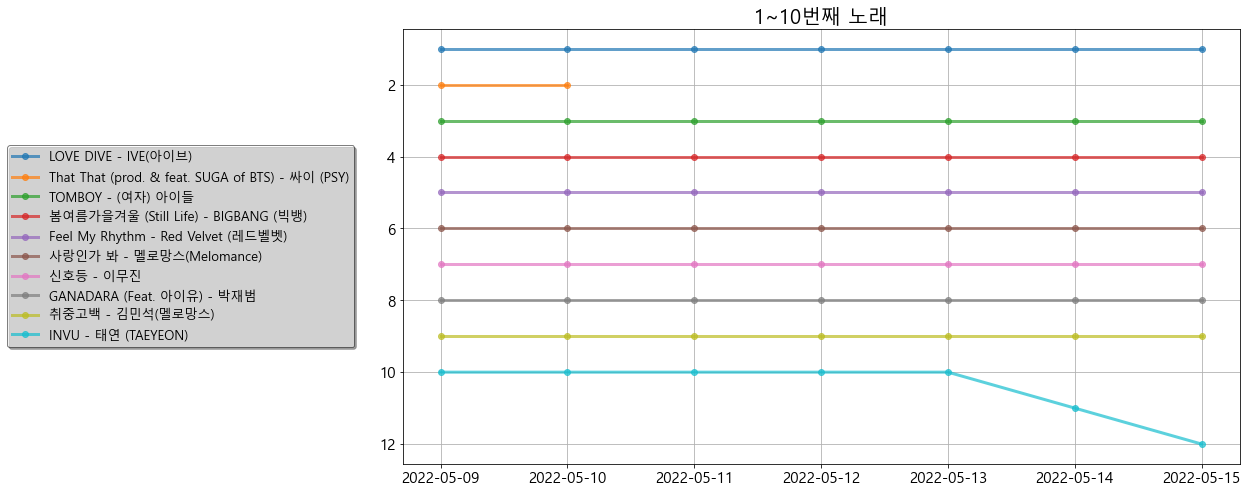

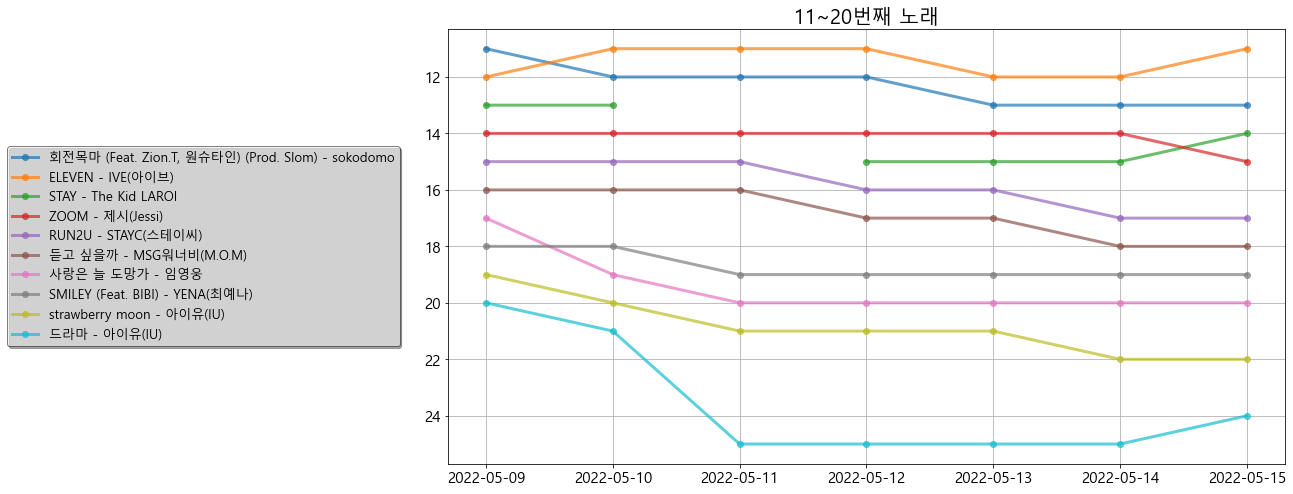

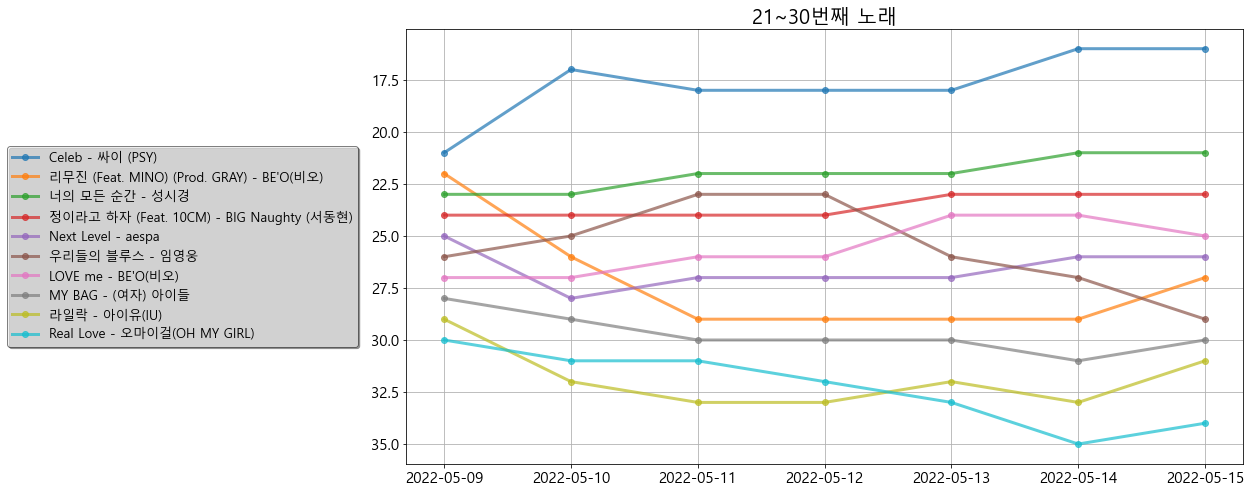

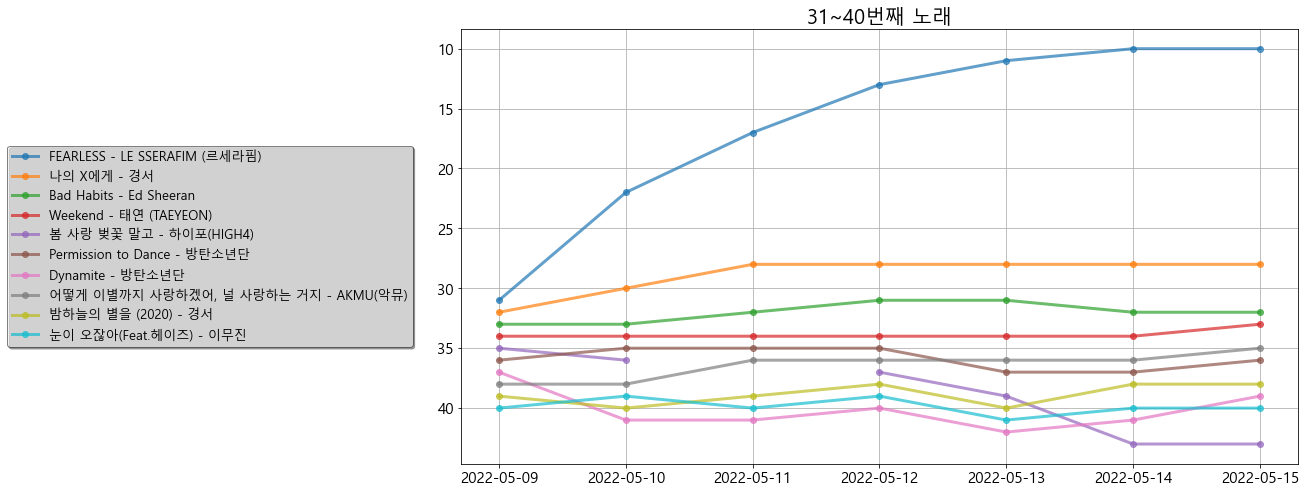

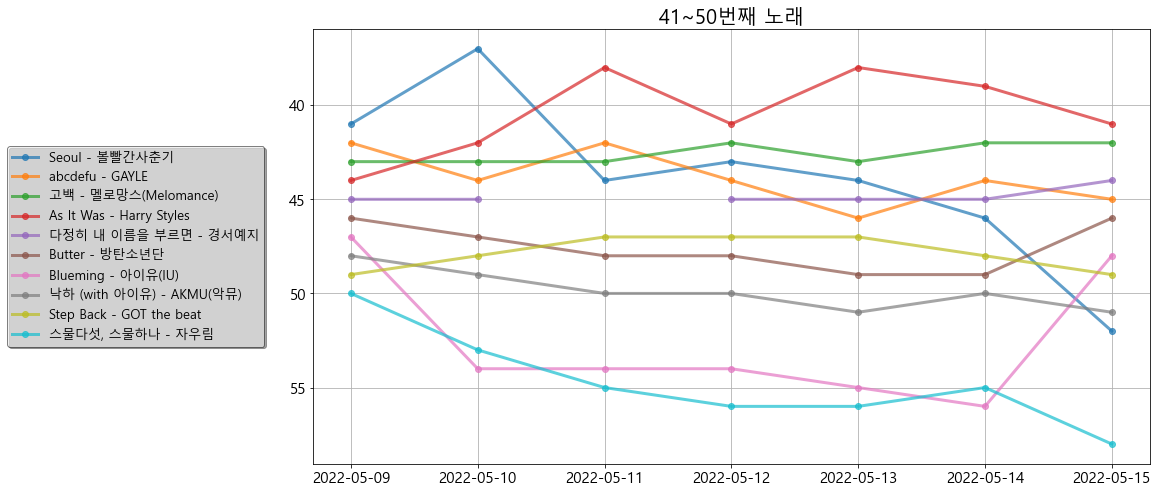

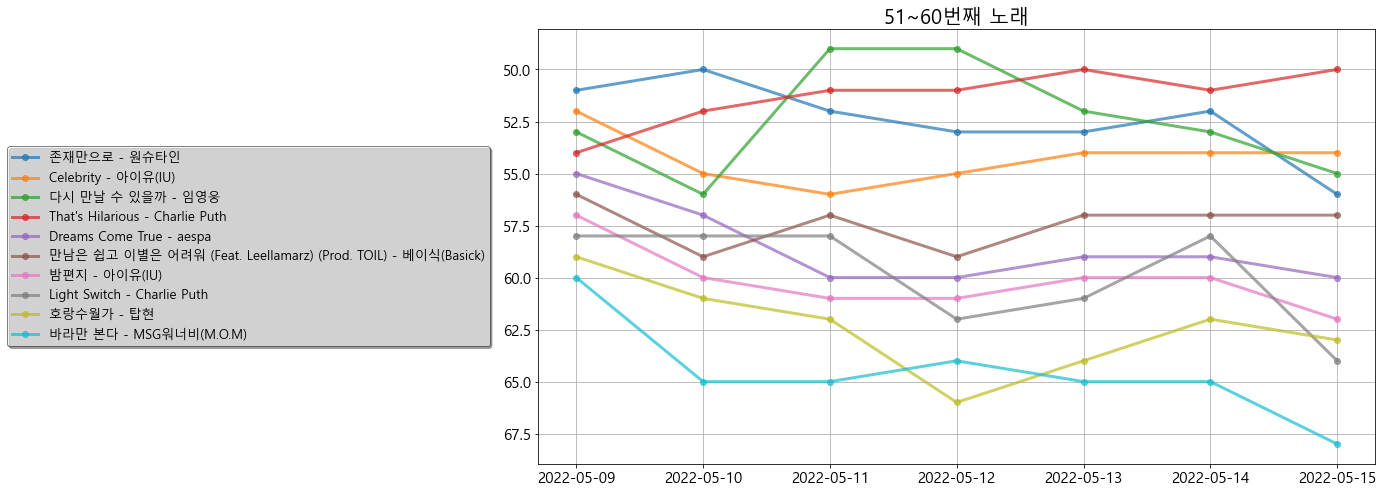

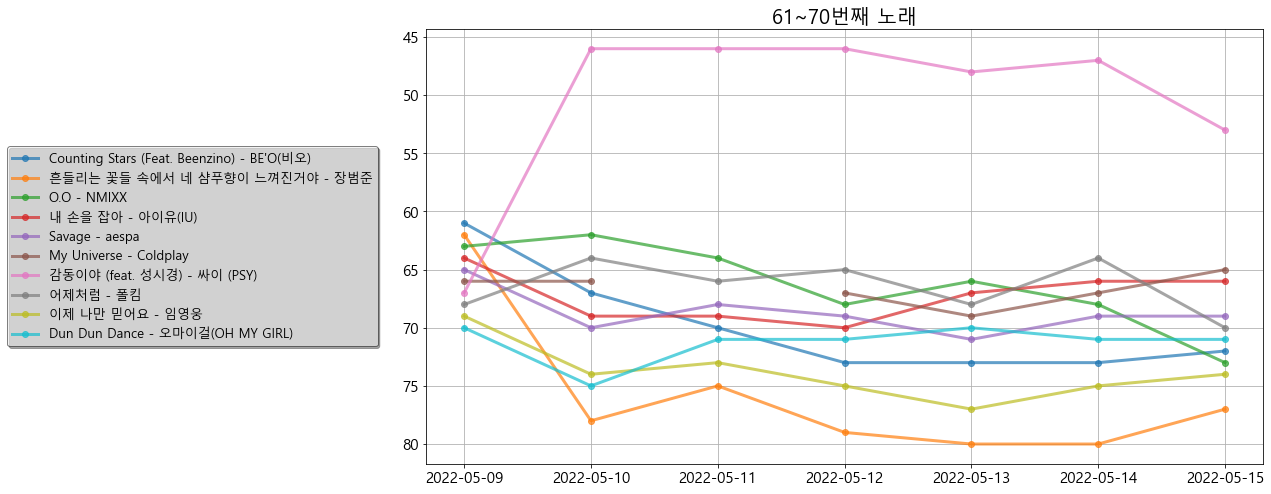

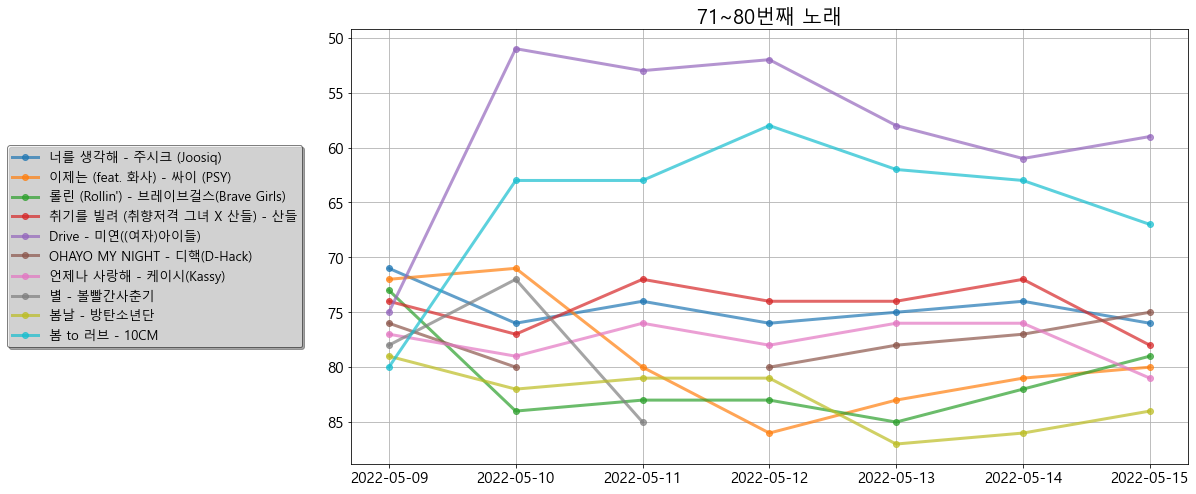

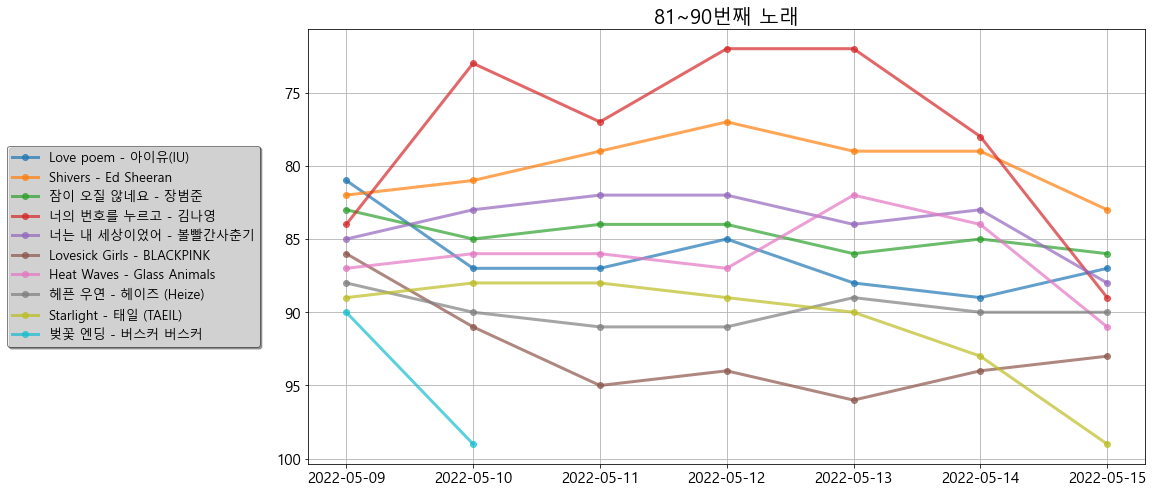

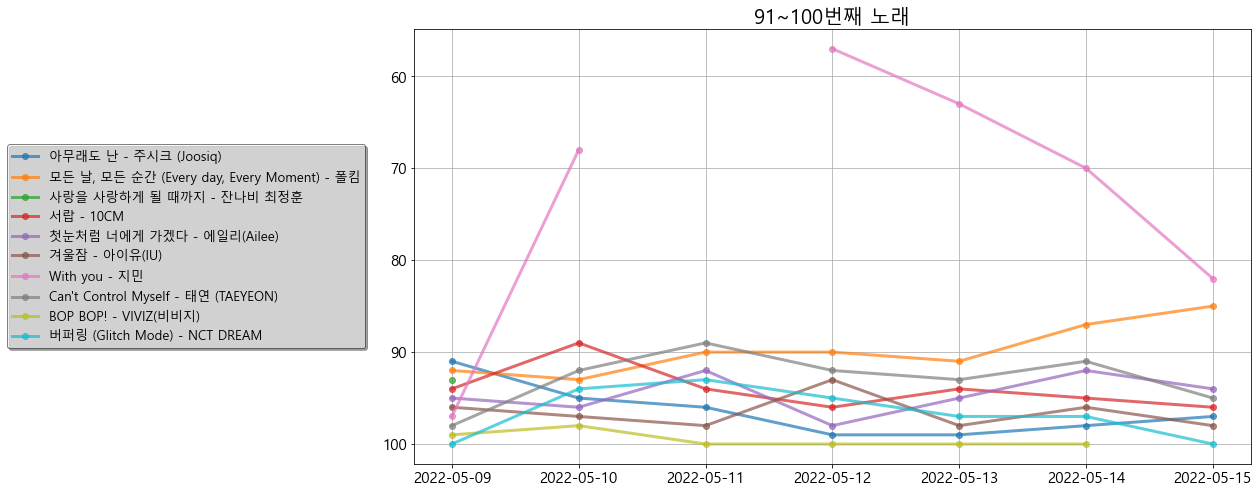

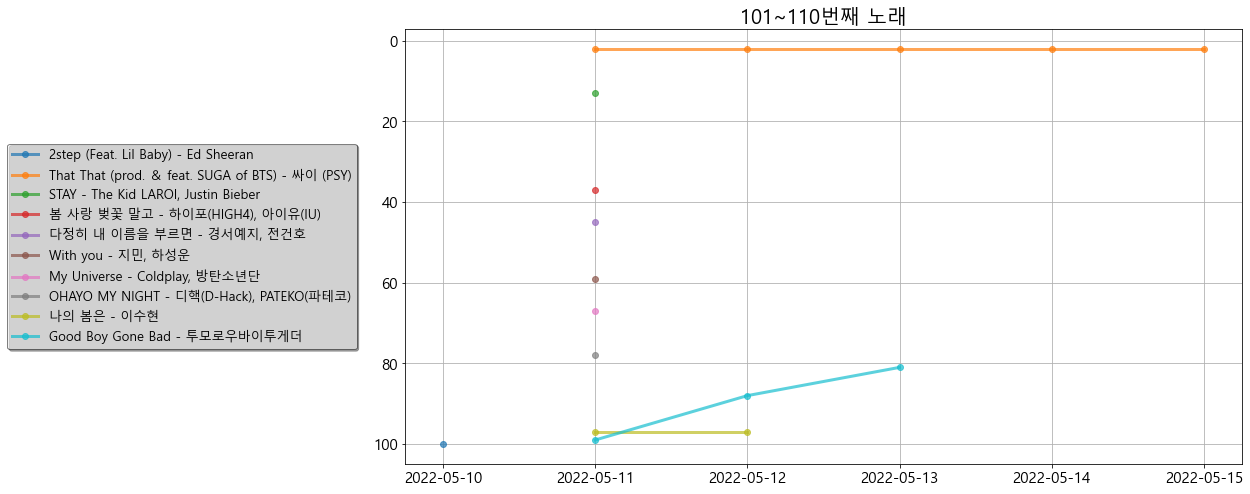

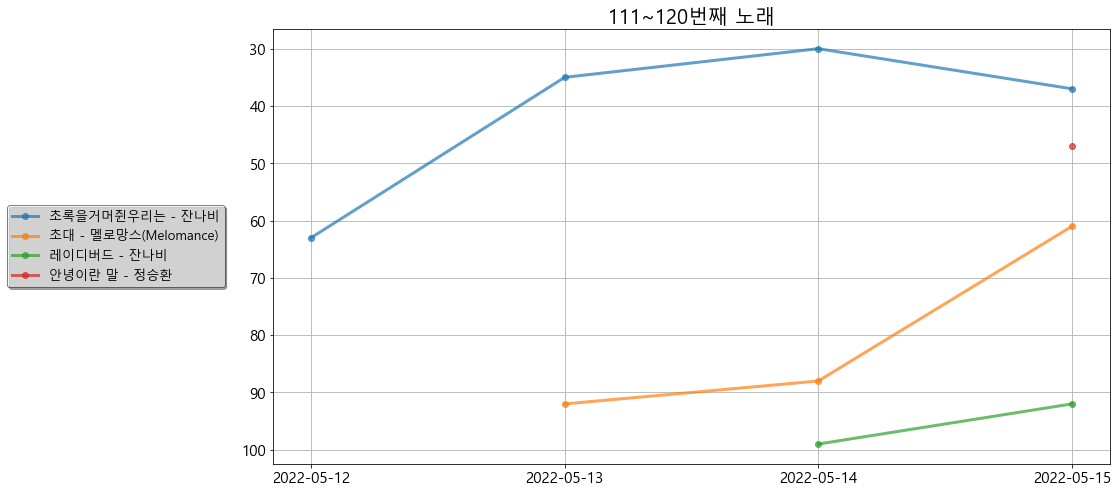

In [32]:
# 음원 사이트
site_list = ['flo', 'bugs', 'genie', 'melon', 'vibe']
total_outlier_df = pd.DataFrame()
for site_name in site_list:
    # 실시간 순위 파일 폴더로 이동
    live_folder = f'/crawled_data/mod_{site_name}/'
    try:
        os.chdir(code_path + live_folder)
    except:
        pass
    file_list = os.listdir()

    df = pd.DataFrame()
    for one in file_list:
        temp = pd.read_excel(one)
        df = pd.concat([df, temp], ignore_index=True)
    df['날짜'] = df['날짜'].astype(str)
    sliced_df = df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)].reset_index(drop=True)
    # 이번주 날짜 df
    dates = pd.date_range(start_date, end_date)
    basic_date_df = pd.DataFrame({'날짜':dates})
    basic_date_df['날짜'] = basic_date_df['날짜'].astype('str')
    # 음원의 유일한 곡, 가수 명 남기기
    unique_sliced_df = sliced_df.drop_duplicates(['곡', '가수']).reset_index(drop=True)
    # 음원별 순위변동 추가 df
    song_df_list = []
    for i in range(unique_sliced_df.shape[0]):
        temp = unique_sliced_df.iloc[i:i+1, :].reset_index(drop=True)
        one_df = sliced_df[(sliced_df['곡'] == temp['곡'][0]) & (sliced_df['가수'] == temp['가수'][0])].reset_index(drop=True)
        one_df['순위변동'] = - ( one_df['순위'] - one_df['순위'].shift(1) )
        one_df['순위변동'] = one_df['순위변동'].fillna(0)
        one_df['순위변동'] = one_df['순위변동'].astype('int64')
        merged_df = pd.merge(basic_date_df, one_df, how='left', on='날짜')
        site = merged_df['사이트'].value_counts().index[0]
        title = merged_df['곡'].value_counts().index[0]
        artist = merged_df['가수'].value_counts().index[0]
        album = merged_df['앨범'].value_counts().index[0]
        agency = merged_df['소속사'].value_counts().index[0]
        agency_type = merged_df['소속사_분류'].value_counts().index[0]
        merged_df['사이트'] = merged_df['사이트'].fillna(site)
        merged_df['곡'] = merged_df['곡'].fillna(title)
        merged_df['가수'] = merged_df['가수'].fillna(artist)
        merged_df['앨범'] = merged_df['앨범'].fillna(album)
        merged_df['소속사'] = merged_df['소속사'].fillna(agency)
        merged_df['소속사_분류'] = merged_df['소속사_분류'].fillna(agency_type)
        song_df_list.append(merged_df)
    # 그래프 저장할 폴더
    save_folder = f'/crawled_data/outlier_data/{start_date}_{end_date}/{site_name}/'
    # 그래프 출력
    t = 0
    for i in range( math.ceil(len(song_df_list)/number) ):
        plt.figure( figsize=(15, 8) )
        ax = plt.axes()
        ax.invert_yaxis()
        graph_df = song_df_list[i*number:(i+1)*number]
        plt.grid(True)
        for one in graph_df:
            title = one['곡'].value_counts().index.values[0]
            artist = one['가수'].value_counts().index.values[0]
            song_label = title + ' - ' + artist
            plt.plot(one['날짜'], one['순위'], '-o', label=song_label, linewidth=3, alpha=0.7)
        t =  t + number
        plt.title(f'{t-(number-1)}~{t}번째 노래', fontdict={'size':20})
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(framealpha=0.5, fontsize=13, frameon=True, edgecolor='k', shadow=True, loc='center right', bbox_to_anchor=(-0.05,0.5))
        plt.savefig(code_path + save_folder + f'[{site_name}]{start_date}_{end_date}_그래프{t:0>2}.png', bbox_inches='tight')

    # 이번주 모든 노래 데이터 병합
    total_df = pd.DataFrame()
    for one in song_df_list:
        total_df = pd.concat([total_df, one], ignore_index=True)
    # 음원의 유일한 곡, 가수만 남기기
    unique_music_df = total_df.sort_values(['사이트', '곡', '가수', '순위']).reset_index(drop=True).drop_duplicates(['곡', '가수'], ignore_index=True)
    # 해당 음원의 순위변동이 양수인 df 추출
    mean_unique_music_df = pd.DataFrame()
    for i in range(unique_music_df.shape[0]):
        title = unique_music_df['곡'][i]
        artist = unique_music_df['가수'][i]
        temp = total_df[ (total_df['곡'] == title) & (total_df['가수'] == artist) & (total_df['순위변동'] > 0)].reset_index(drop=True)
        # 해당 음원의 순위변동평균
        temp['순위변동평균(양수)'] = round( temp['순위변동'].mean(), 1 )
        # 해당 음원 df의 첫째 줄만 추출
        first_temp = temp.iloc[0:1, :]
        mean_unique_music_df = pd.concat([mean_unique_music_df, first_temp], ignore_index=True)
    # 급등 음원 추출
    u_outlier = 30
    outlier_df = mean_unique_music_df[mean_unique_music_df['순위변동평균(양수)'] > u_outlier].reset_index(drop=True)
    # 파일 저장할 폴더 생성
    mod_start_date = start_date.replace('-','')
    mod_end_date = end_date.replace('-','')
    path = f'C:/data/Wantreez/Crawling/music/crawled_data/outlier_data/{start_date}_{end_date}/{site_name}/'
    os.makedirs(path, exist_ok=True)
    # 이상치 음원 평균 df 출력
    outlier_df.to_excel(path + f'[{site_name}]{mod_start_date}_{mod_end_date}_mean_outliers.xlsx', index=False)
    print(f'[{site_name}]{mod_start_date}_{mod_end_date}_mean_outliers.xlsx 출력')
    # 이상치 음원 df 종합
    total_outlier_df = pd.concat([total_outlier_df, outlier_df], ignore_index=True)

## 이상치 음원 종합

In [11]:
total_outlier_df.shape

(13, 10)

In [12]:
total_outlier_df.head()

날짜   사이트    순위                      곡            가수  \
0  2022-05-11  Bugs  63.0               Dynamite         방탄소년단   
1  2022-05-13  Bugs  38.0  forEVER (feat. TABLO)      싸이 (PSY)   
2  2022-05-12  Bugs  33.0                    꽃 길  BIGBANG (빅뱅)   
3  2022-05-11  Bugs  44.0               너의 모든 순간           성시경   
4  2022-05-14  Bugs  62.0             너의 번호를 누르고           김나영   

                                  앨범       소속사 소속사_분류  순위변동  순위변동평균(양수)  
0         Dynamite (DayTime Version)       빅히트    빅히트  27.0        34.3  
1                                싸다9  P NATION     기타  42.0        42.0  
2                                꽃 길        YG     YG  61.0        61.0  
3  별에서 온 그대 (SBS 수목드라마) OST - Part.7       SSK     기타  54.0        51.0  
4                         너의 번호를 누르고      플렉스엠     기타  35.0        35.0

In [13]:
idx = total_outlier_df[total_outlier_df['소속사'] == '해외'].index
idx

Int64Index([], dtype='int64')

In [14]:
mod_total_outlier_df = total_outlier_df.drop(idx).reset_index(drop=True)
mod_total_outlier_df = mod_total_outlier_df[['날짜', '순위변동평균(양수)', '곡', '가수', '소속사', '순위', '앨범', '소속사_분류', '순위변동', '사이트']]

In [15]:
mod_total_outlier_df.head()

날짜  순위변동평균(양수)                      곡            가수       소속사  \
0  2022-05-11        34.3               Dynamite         방탄소년단       빅히트   
1  2022-05-13        42.0  forEVER (feat. TABLO)      싸이 (PSY)  P NATION   
2  2022-05-12        61.0                    꽃 길  BIGBANG (빅뱅)        YG   
3  2022-05-11        51.0               너의 모든 순간           성시경       SSK   
4  2022-05-14        35.0             너의 번호를 누르고           김나영      플렉스엠   

     순위                                 앨범 소속사_분류  순위변동   사이트  
0  63.0         Dynamite (DayTime Version)    빅히트  27.0  Bugs  
1  38.0                                싸다9     기타  42.0  Bugs  
2  33.0                                꽃 길     YG  61.0  Bugs  
3  44.0  별에서 온 그대 (SBS 수목드라마) OST - Part.7     기타  54.0  Bugs  
4  62.0                         너의 번호를 누르고     기타  35.0  Bugs

## 2-1 주간 음원 변동 특이사항
* 이상치 음원 df 출력

In [16]:
save_total_oulier_df_path = f'/crawled_data/outlier_data/{start_date}_{end_date}/'
code_path + save_total_oulier_df_path

'c:/data/Wantreez/Crawling/music/crawled_data/outlier_data/2022-05-09_2022-05-15/'

In [17]:
mod_total_outlier_df.to_excel(code_path + save_total_oulier_df_path + f'{start_date}_{end_date}_total_outlier.xlsx', index=False)
print(f'{start_date}_{end_date}_total_outlier.xlsx 출력')

2022-05-09_2022-05-15_total_outlier.xlsx 출력


## 3-1-1. 순위 급상승 음원
* 이상치 음원 순위변동 평균 그래프

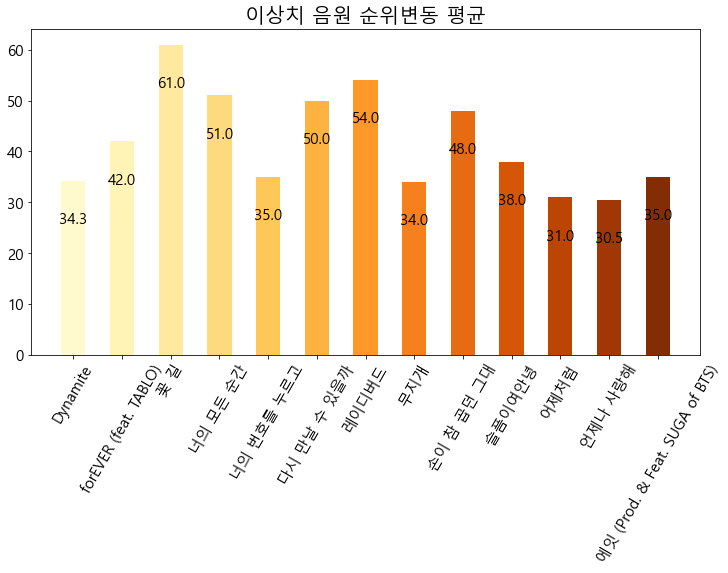

In [18]:
plt.figure(figsize=(12, 6))
colors = sns.color_palette('YlOrBr', mod_total_outlier_df.shape[0])
plt.bar('곡', '순위변동평균(양수)', data=mod_total_outlier_df, color=colors, width=0.5)
plt.title(f'이상치 음원 순위변동 평균', fontdict={'size':20})
for i in range(mod_total_outlier_df.shape[0]):
    plt.text(i, mod_total_outlier_df['순위변동평균(양수)'][i] - mod_total_outlier_df['순위변동평균(양수)'].max()*0.1, round(mod_total_outlier_df['순위변동평균(양수)'][i], 1), verticalalignment='top', horizontalalignment='center', fontsize=15)
plt.xticks(fontsize=15, rotation=60)
plt.yticks(fontsize=15);
plt.savefig(code_path + save_total_oulier_df_path + f'{start_date}_{end_date}_total_outlier.png', bbox_inches='tight')

## 4-2-1. 소속사별 진입 음원
* 이상치 음원들의 평균 순위

In [117]:
# 음원 사이트
site_list = ['flo', 'bugs', 'genie', 'melon', 'vibe']
outlier_agency_df = pd.DataFrame()
for site_name in site_list:
    # 실시간 순위 파일 폴더로 이동
    live_folder = f'/crawled_data/mod_{site_name}/'
    try:
        os.chdir(code_path + live_folder)
    except:
        pass
    file_list = os.listdir()

    df = pd.DataFrame()
    for one in file_list:
        temp = pd.read_excel(one)
        df = pd.concat([df, temp], ignore_index=True)
    df['날짜'] = df['날짜'].astype(str)
    sliced_df = df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)].reset_index(drop=True)
 
    # 이상치 음원의 기획사 소속 가수 평균
    for agency in mod_total_outlier_df['소속사'].unique():
        temp = sliced_df[sliced_df['소속사'] == agency].reset_index(drop=True)
        outlier_agency_df = pd.concat([outlier_agency_df, temp], ignore_index=True)

In [118]:
outlier_agency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사이트     1313 non-null   object
 1   날짜      1313 non-null   object
 2   순위      1313 non-null   int64 
 3   곡       1313 non-null   object
 4   가수      1313 non-null   object
 5   앨범      1313 non-null   object
 6   소속사     1313 non-null   object
 7   소속사_분류  1313 non-null   object
dtypes: int64(1), object(7)
memory usage: 82.2+ KB


In [119]:
mean_outlier_agency_df = outlier_agency_df.groupby(['소속사', '사이트', '곡', '가수']).agg({'순위':'mean'}).reset_index()

In [120]:
mean_outlier_agency_df = mean_outlier_agency_df.rename(columns={'순위':'순위평균'})
mean_outlier_agency_df = mean_outlier_agency_df[['소속사', '곡', '가수', '순위평균', '사이트']]
mean_outlier_agency_df['순위평균'] = round(mean_outlier_agency_df['순위평균'], 1)

In [121]:
mean_outlier_agency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   소속사     228 non-null    object 
 1   곡       228 non-null    object 
 2   가수      228 non-null    object 
 3   순위평균    228 non-null    float64
 4   사이트     228 non-null    object 
dtypes: float64(1), object(4)
memory usage: 9.0+ KB


In [122]:
mean_outlier_agency_df.head()

소속사                곡       가수  순위평균   사이트
0  EDAM         Blueming  아이유(IU)  86.8  Bugs
1  EDAM        Celebrity  아이유(IU)  82.0  Bugs
2  EDAM  strawberry moon  아이유(IU)  52.0  Bugs
3  EDAM          내 손을 잡아  아이유(IU)  75.0  Bugs
4  EDAM              드라마  아이유(IU)  43.7  Bugs

In [123]:
# 이상치 음원 소속사 음원 순위 평균 df 출력
mean_outlier_agency_df.to_excel(code_path + save_total_oulier_df_path + f'{start_date}_{end_date}_mean_outlier_agency.xlsx', index=False)
print(f'{start_date}_{end_date}_mean_outlier_agency.xlsx 출력')

2022-05-09_2022-05-15_mean_outlier_agency.xlsx 출력


## 4-1-1. 기획사별 음원차트 진입 요약
* 이상치 음원 기획사별 분석

In [125]:
agency_music_df = mean_outlier_agency_df.drop_duplicates(['소속사', '곡', '가수']).reset_index(drop=True)

In [127]:
agency_music_df.head()

소속사                곡       가수  순위평균   사이트
0  EDAM         Blueming  아이유(IU)  86.8  Bugs
1  EDAM        Celebrity  아이유(IU)  82.0  Bugs
2  EDAM  strawberry moon  아이유(IU)  52.0  Bugs
3  EDAM          내 손을 잡아  아이유(IU)  75.0  Bugs
4  EDAM              드라마  아이유(IU)  43.7  Bugs

In [128]:
agency_music_df.groupby(['소속사']).agg('size').reset_index()

소속사   0
0          EDAM  27
1        NEXTAR   3
2      P NATION  29
3           SSK   2
4            YG  15
5  neuron music   4
6         물고기뮤직  14
7           빅히트  12
8         페포니뮤직   5
9          플렉스엠   1

In [129]:
mean_outlier_agency_df.groupby(['소속사']).agg('size').reset_index()

소속사   0
0          EDAM  40
1        NEXTAR   5
2      P NATION  45
3           SSK   6
4            YG  23
5  neuron music   9
6         물고기뮤직  54
7           빅히트  32
8         페포니뮤직  11
9          플렉스엠   3

In [130]:
num_music = mean_outlier_agency_df.groupby(['소속사']).agg('size').reset_index().sort_values(0, ascending=False)
num_music.columns = ['소속사', '음원수량']
num_music

소속사  음원수량
6         물고기뮤직    54
2      P NATION    45
0          EDAM    40
7           빅히트    32
4            YG    23
8         페포니뮤직    11
5  neuron music     9
3           SSK     6
1        NEXTAR     5
9          플렉스엠     3

In [131]:
num_music_df = pd.merge(mean_outlier_agency_df, num_music, how='left', on='소속사')
num_music_df.head()

소속사                곡       가수  순위평균   사이트  음원수량
0  EDAM         Blueming  아이유(IU)  86.8  Bugs    40
1  EDAM        Celebrity  아이유(IU)  82.0  Bugs    40
2  EDAM  strawberry moon  아이유(IU)  52.0  Bugs    40
3  EDAM          내 손을 잡아  아이유(IU)  75.0  Bugs    40
4  EDAM              드라마  아이유(IU)  43.7  Bugs    40

In [132]:
max_num_music = num_music_df.sort_values(['음원수량', '순위평균'], ascending=False).iloc[0:1, :]
max_num_music

소속사           곡   가수  순위평균   사이트  음원수량
133  물고기뮤직  손이 참 곱던 그대  임영웅  82.3  Bugs    54

In [133]:
max_rank_music = num_music_df.sort_values('순위평균', ascending=True).iloc[0:1, :]
max_rank_music

소속사                                      곡        가수  순위평균    사이트  \
79  P NATION  That That (prod. & feat. SUGA of BTS)  싸이 (PSY)   1.0  Melon   

    음원수량  
79    45

In [134]:
agency_in_chart = pd.concat([max_num_music, max_rank_music], ignore_index=True)
agency_in_chart = agency_in_chart[['소속사', '음원수량', '순위평균', '가수', '곡', '사이트']]
agency_in_chart

소속사  음원수량  순위평균        가수                                      곡  \
0     물고기뮤직    54  82.3       임영웅                             손이 참 곱던 그대   
1  P NATION    45   1.0  싸이 (PSY)  That That (prod. & feat. SUGA of BTS)   

     사이트  
0   Bugs  
1  Melon

In [135]:
# 이상치 음원 소속사별 음원차트 진입 요약 df 출력
agency_in_chart.to_excel(code_path + save_total_oulier_df_path + f'{start_date}_{end_date}_agency_in_chart.xlsx', index=False)
print(f'{start_date}_{end_date}_agency_in_chart.xlsx 출력')

2022-05-09_2022-05-15_agency_in_chart.xlsx 출력


## 4-1-2. 기획사 소셜미디어 관심도 요약

In [518]:
# 파일 저장 폴더 생성
naver_datalab_path = f'/crawled_data/outlier_data/{start_date}_{end_date}/naver_datalab/'
des2 = code_path + naver_datalab_path
os.makedirs(des2, exist_ok=True)
des2

'c:/data/Wantreez/Crawling/music/crawled_data/outlier_data/2022-05-09_2022-05-15/naver_datalab/'

In [524]:
ca.install(True)
driver = webdriver.Chrome()

In [525]:
# 네이버 데이터 랩 검색
for i in range(agency_in_chart.shape[0]):
    # 네이버 데이터 랩 접속
    url = 'https://datalab.naver.com/keyword/trendSearch.naver'
    driver.get(url)
    driver.implicitly_wait(3)
    time.sleep( random.uniform(1, 1.5) )
    driver.maximize_window()

    # 검색어 입력
    word = agency_in_chart['소속사'][i]
    search_box = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[1]/div[1]/input')
    search_box.clear()
    time.sleep( random.uniform(1, 1.5) )
    search_box.send_keys(word)

    # 3개월 picker 클릭
    time_picker = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/label[3]').click()
    time.sleep( random.uniform(1, 1.5) )

    # 주간 클릭
    week_picker = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/div').click()
    time.sleep( random.uniform(0.5, 1) )
    week_button = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/div/ul/li[2]').click()
    time.sleep( random.uniform(0.5, 1) )

    # 검색 버튼 클릭
    search_button = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/a/span').click()
    time.sleep( random.uniform(1, 1.5) )
    driver.implicitly_wait(3)

    # 다운 버튼 클릭
    down_button = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div/div[1]/div[1]/div[1]/div/div/div/div/div/div[1]/div[4]/a').click()
    time.sleep( random.uniform(1, 1.5) )

    # 파일 이름 변경
    down_folder = 'C:/Users/kbjung/Downloads/'
    down_xlsx = 'datalab.xlsx'

    new_down_xlsx = f'{word}.xlsx'
    os.rename(down_folder + down_xlsx, down_folder + new_down_xlsx)

    # 파일 이동
    shutil.move(down_folder + new_down_xlsx, des2 + new_down_xlsx)
    print(f'{new_down_xlsx} 완료.')

C:\Users\kbjung\AppData\Local\Temp/ipykernel_15120/2510828449.py:12: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  search_box = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[1]/div[1]/input')
C:\Users\kbjung\AppData\Local\Temp/ipykernel_15120/2510828449.py:18: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  time_picker = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/label[3]').click()
C:\Users\kbjung\AppData\Local\Temp/ipykernel_15120/2510828449.py:22: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  week_picker = driver.find_element_by_xpath('/html/body/div[2]/div[2]/div[1]/div/div[2]/div[1]/div/form/fieldset/div/div[6]/div[1]/div').click()
C:\Users\kbj

물고기뮤직.xlsx 완료.
P NATION.xlsx 완료.


In [526]:
driver.quit()

### 그래프(음원 순위 변동 사항 대비 소셜미디어내 관심도 추이)

In [532]:
xticks_names = ['5월1주차', '5월2주차']

In [535]:
des2

'c:/data/Wantreez/Crawling/music/crawled_data/outlier_data/2022-05-09_2022-05-15/naver_datalab/'

소속사_소셜관심도.png 저장 완료.


C:\Users\kbjung\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\kbjung\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


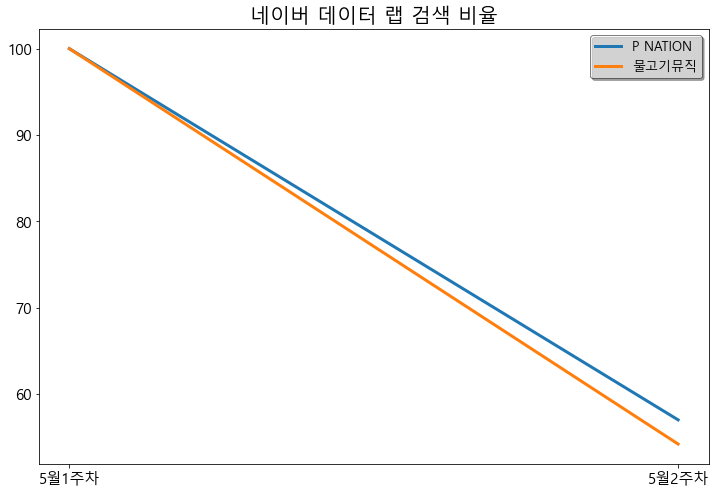

In [557]:
# 그래프 생성
file_list = os.listdir(des2)
plt.figure( figsize=(12,8) )
for one in file_list:
    title = one.split('.')[0]
    if title in agency_in_chart['소속사'].values:
        # print(title)
        temp = pd.read_excel(des2 + one)
        temp = temp.reset_index(drop=True)
        temp = temp.iloc[6:, :].reset_index(drop=True)
        temp.columns = ['날짜', '검색비율']

        date_list = pd.date_range(end=start_date, periods=2, freq='W-MON')
        start_week = str(date_list[0]).split(' ')[0]
        end_week = str(date_list[-1]).split(' ')[0]
        week_temp = temp[ (temp['날짜'] >= start_week) & (temp['날짜'] <= end_week)].reset_index(drop=True)
        week_temp['검색비율'] = week_temp['검색비율'].astype(float)
        week_temp['검색비율'] = round(week_temp['검색비율'], 1)
        
        x = xticks_names
        y = week_temp['검색비율']

        plt.plot(x, y, linewidth=3, label=title)

plt.title(f"네이버 데이터 랩 검색 비율", fontsize=20)
plt.xticks(xticks_names ,fontsize=15)
plt.yticks(fontsize=15)
plt.legend(framealpha=0.5, fontsize=13, frameon=True, edgecolor='k', shadow=True);
plt.savefig(des2 + '소속사_소셜관심도.png')
print('소속사_소셜관심도.png 저장 완료.')

# 코드 마지막